In [164]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import warnings

warnings.filterwarnings('ignore')

import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
import time
from sklearn.metrics import precision_score, recall_score, f1_score
import scipy.sparse as sparse
import implicit
import random
from scipy.sparse import csr_matrix
from sklearn import metrics


In [165]:
# pip install implicit

In [166]:
train_data=pd.read_csv("basket_data_by_date_train.csv")
test_data=pd.read_csv("basket_data_by_date_test.csv")

In [167]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   BillNo      40000 non-null  int64  
 1   Itemname    40000 non-null  object 
 2   Quantity    40000 non-null  int64  
 3   Date        40000 non-null  object 
 4   Price       40000 non-null  float64
 5   CustomerID  40000 non-null  int64  
 6   cost        40000 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 2.1+ MB


In [168]:
train_data.describe()

,BillNo,Quantity,Price,CustomerID,cost
count,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,540254.879225,3.487700,3.732165,15577.606525,11.097411
std,2380.444952,2.611766,5.711630,1730.347123,13.298301
min,536365.000000,1.000000,0.100000,12347.000000,0.140000
25%,538093.000000,1.000000,1.650000,14224.000000,3.300000
50%,540373.000000,2.000000,2.950000,15570.000000,7.950000
75%,542360.000000,6.000000,4.650000,17220.000000,15.800000
max,544398.000000,10.000000,295.000000,18283.000000,527.700000


- **Quantity:** On average, each transaction involves buying around 3 to 4 items. The transactions range is from 1 to 10.
- **Price:** The cheapest item costs just `$0.1`, while the most expensive one is `$295.00`.
- **CustomerID:** The lowest customer number is 12347, and the highest is 18283.
- **Cost:** The smallest transaction costs just `$0.14`., while the largest one is `$527.7`.

In [169]:
train_data.head(5)

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850,20.34
1,536365,GLASS STAR FROSTED T-LIGHT HOLDER,6,1/12/2010 8:26,4.25,17850,25.50
2,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850,15.30
3,536365,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850,20.34
4,536365,SET 7 BABUSHKA NESTING BOXES,2,1/12/2010 8:26,7.65,17850,15.30


In [170]:
train_data.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

In [171]:
test_data.describe()

,BillNo,Quantity,Price,CustomerID,cost
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,545209.692000,3.672100,3.971454,15433.082900,11.840678
std,492.638789,2.639788,6.777596,1616.660727,13.086198
min,544398.000000,1.000000,0.160000,12352.000000,0.190000
25%,544795.000000,2.000000,1.650000,14227.000000,3.750000
50%,545181.000000,3.000000,2.950000,15358.000000,9.900000
75%,545664.000000,6.000000,4.950000,16931.000000,16.500000
max,546084.000000,10.000000,195.000000,18283.000000,290.000000


For the test data:
- **Quantity:** On average, each transaction involves buying around 3.67 items. The transactions range is from 1 to 10.
- **Price:** The cheapest item costs just `$0.10`, while the most expensive one is `$195.00`.
- **CustomerID:** The lowest customer number is 12352, and the highest is 18283.
- **Cost:** The smallest transaction costs just `$0.19` , while the largest one is `$290.00`.

In [172]:
test_data.head(5)

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,544398.0,JUMBO SHOPPER VINTAGE RED PAISLEY,1.0,18/02/2011 12:27,1.95,15311.0,1.95
1,544398.0,ZINC WILLIE WINKIE CANDLE STICK,4.0,18/02/2011 12:27,0.85,15311.0,3.40
2,544398.0,LOVE BUILDING BLOCK WORD,2.0,18/02/2011 12:27,5.95,15311.0,11.90
3,544398.0,HANGING FAIRY CAKE DECORATION,3.0,18/02/2011 12:27,2.10,15311.0,6.30
4,544398.0,RED HEART SHAPE LOVE BUCKET,1.0,18/02/2011 12:27,2.95,15311.0,2.95


In [173]:
#removing any rows containing missing values (NaN)
test_data = test_data.dropna()

In [174]:
#checking null values in test dataset
test_data.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

In [175]:
# Checking for duplicate rows
train_data.duplicated().sum()

797

In [176]:
# Checking for duplicate rows
test_data.duplicated().sum()

150

In [177]:
# Removing duplicate rows
train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()

In [178]:
#Lowering all text
train_data=train_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)
test_data=test_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [179]:
format_string = "%d/%m/%Y %H:%M"
# Converting 'Date' column to datetime objects
train_data['Date'] = pd.to_datetime(train_data['Date'], format=format_string)
test_data['Date'] = pd.to_datetime(test_data['Date'], format=format_string)

In [180]:
#Merging to plot graphs
dataset = pd.concat([train_data, test_data])

In [181]:
item_count= dataset.groupby(["Itemname"]).count()
item_count

,BillNo,Quantity,Date,Price,CustomerID,cost
Itemname,,,,,,
10 colour spaceboy pen,5,5,5,5,5,5
12 coloured party balloons,11,11,11,11,11,11
12 daisy pegs in wood box,22,22,22,22,22,22
12 egg house painted wood,16,16,16,16,16,16
12 ivory rose peg place settings,19,19,19,19,19,19
...,...,...,...,...,...,...
zinc heart lattice t-light holder,7,7,7,7,7,7
zinc heart lattice tray oval,2,2,2,2,2,2
zinc metal heart decoration,45,45,45,45,45,45


Text(0.5, 1.0, 'Top 10 Popular Sold Items')

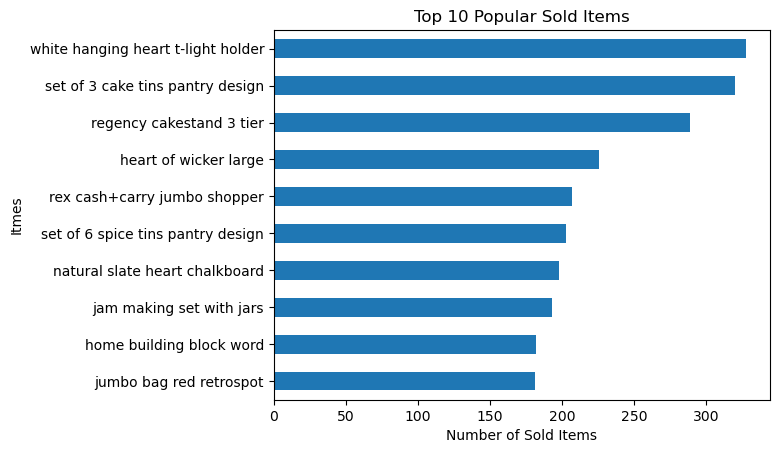

In [182]:
# Top 10 Popular Sold Items
df= dataset.groupby(["Itemname"])["Quantity"].count().sort_values(axis= 0,ascending =False)
df = df[:10,].sort_values(ascending = True)
df.plot(kind = "barh")
plt.ylabel('Itmes')
plt.xlabel('Number of Sold Items')
plt.title('Top 10 Popular Sold Items')

In [183]:
df = dataset.groupby("CustomerID")["CustomerID"].count()
df

CustomerID
12347.0     32
12350.0      2
12352.0     13
12356.0      1
12361.0      5
          ... 
18259.0      3
18260.0     16
18269.0      5
18280.0     10
18283.0    129
Name: CustomerID, Length: 1660, dtype: int64

In [184]:
df = dataset.groupby("CustomerID")["CustomerID"].count().nlargest(10)
df

CustomerID
14606.0    767
17841.0    764
12748.0    722
15311.0    619
15039.0    392
18118.0    344
14796.0    295
17850.0    282
14527.0    245
17811.0    244
Name: CustomerID, dtype: int64

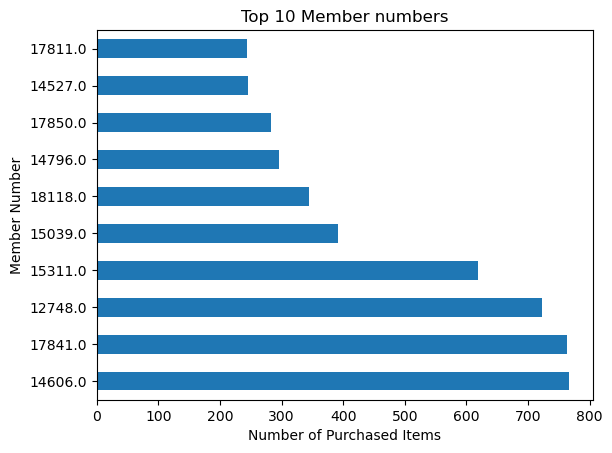

In [185]:
df = dataset.groupby("CustomerID")["CustomerID"].count().nlargest(10)
# Plot the top 10 member numbers
df.plot(kind="barh")
plt.ylabel('Member Number')
plt.xlabel('Number of Purchased Items')
plt.title('Top 10 Member numbers')
plt.show()

In [186]:
dataset[dataset['Quantity'] < 1]

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost


In [187]:
zero_price_count = len(dataset[dataset['cost'] == 0])
print("Number of rows where price is zero:", zero_price_count)
# Counting the number of rows where the price is negative
negative_price_count = len(dataset[dataset['cost'] < 0])
print("Number of rows where price is negative:", negative_price_count)

Number of rows where price is zero: 0
Number of rows where price is negative: 0


Month
2010-12    189586.78
Name: cost, dtype: float64
Month
2011-01    163000.93
2011-02    149459.02
2011-03     56291.37
Name: cost, dtype: float64


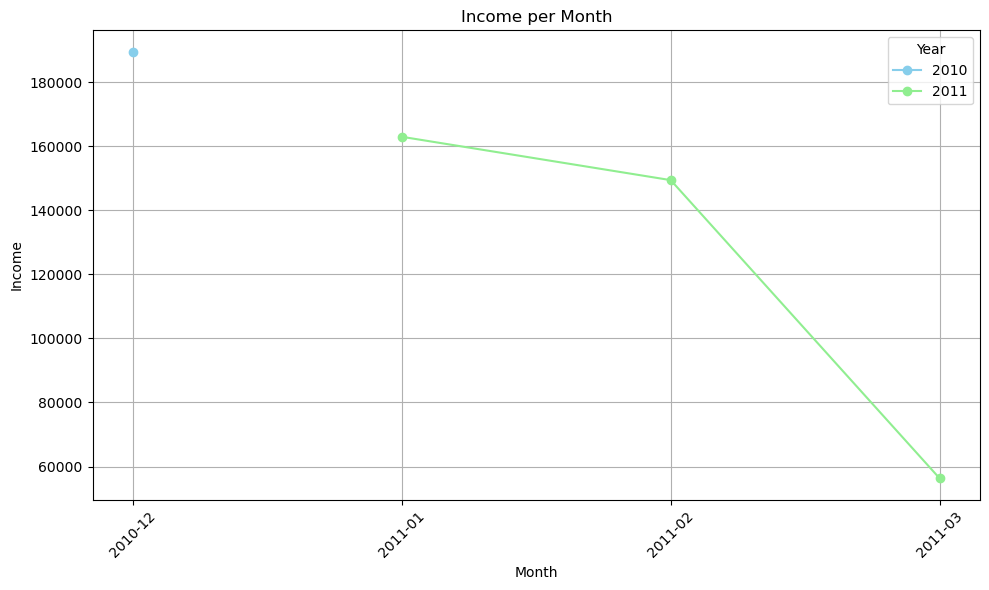

In [188]:
def plot_income_per_month(data, years, colors):
    plt.figure(figsize=(10, 6))

    for year, color in zip(years, colors):
        df_year = data[data['Date'].dt.year == year]
        df_year['Month'] = df_year['Date'].dt.strftime('%Y-%m')
        monthly_income = df_year.groupby('Month')['cost'].sum()
        print(monthly_income)
        plt.plot(monthly_income.index, monthly_income.values, marker='o', color=color, label=str(year))

    plt.title('Income per Month')
    plt.xlabel('Month')
    plt.ylabel('Income')
    plt.xticks(rotation=45)
    plt.legend(title='Year')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
years = [2010, 2011]
colors = ['skyblue', 'lightgreen']
plot_income_per_month(dataset, years, colors)

In [189]:
train_df=train_data.copy()
test_df = test_data.copy()

In [190]:
train_rating_df = pd.DataFrame(columns=["CustomerID", "Itemname", "Rating"])

for i in range(len(train_df)):
    customer_id = train_df.iloc[i]["CustomerID"]
    item_name = train_df.iloc[i]["Itemname"]
    temp = train_df.loc[(train_df["CustomerID"] == customer_id) & (train_df["Itemname"] == item_name)]
    create_row = {"CustomerID": customer_id, "Itemname": item_name, "Rating": len(temp)}
    train_rating_df = pd.concat([train_rating_df, pd.DataFrame([create_row])], ignore_index=True)

In [191]:
test_rating_df = pd.DataFrame(columns=["CustomerID", "Itemname", "Rating"])

for i in range(len(test_df)):
    customer_id = test_df.iloc[i]["CustomerID"]
    item_name = test_df.iloc[i]["Itemname"]
    temp = test_df.loc[(test_df["CustomerID"] == customer_id) & (test_df["Itemname"] == item_name)]
    create_row = {"CustomerID": customer_id, "Itemname": item_name, "Rating": len(temp)}
    test_rating_df = pd.concat([test_rating_df, pd.DataFrame([create_row])], ignore_index=True)

In [192]:
#droping duplicates
train_rating = train_rating_df.drop_duplicates()
test_rating = test_rating_df.drop_duplicates()

In [193]:
unique_customer_count = dataset['CustomerID'].unique()
unique_items_count = dataset['Itemname'].unique()

In [194]:
print("Total customer count:", len(unique_customer_count))
print("Total items count:", len(unique_items_count))

Total customer count: 1660
Total items count: 2641


In [195]:
train_rating_piv_df = pd.DataFrame(pd.pivot_table(train_rating, index='Itemname', columns='CustomerID', values='Rating'))
train_rating_piv_df.fillna(0, inplace=True)

In [196]:
train_rating_piv_df

CustomerID,12347,12350,12352,12356,12362,12370,12373,12377,12383,12386,...,18230,18233,18239,18245,18250,18257,18259,18260,18269,18283
Itemname,,,,,,,,,,,,,,,,,,,,,
10 colour spaceboy pen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 coloured party balloons,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 daisy pegs in wood box,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 egg house painted wood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 ivory rose peg place settings,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zinc heart lattice t-light holder,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zinc heart lattice tray oval,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zinc metal heart decoration,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [197]:
similarity_matrix_train_df = pd.DataFrame(cosine_similarity(train_rating_piv_df, train_rating_piv_df), index=train_rating_piv_df.index, columns=train_rating_piv_df.index)
similarity_matrix_train_df

Itemname,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 pencil small tube woodland,12 pencils small tube red retrospot,12 pencils small tube skull,12 pencils tall tube posy,...,yuletide images s/6 paper boxes,zinc finish 15cm planter pots,zinc heart lattice 2 wall planter,zinc heart lattice charger large,zinc heart lattice charger small,zinc heart lattice t-light holder,zinc heart lattice tray oval,zinc metal heart decoration,zinc top 2 door wooden shelf,zinc willie winkie candle stick
Itemname,,,,,,,,,,,,,,,,,,,,,
10 colour spaceboy pen,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.096225,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.078087,0.000000,0.106600
12 coloured party balloons,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.196116,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
12 daisy pegs in wood box,0.000000,0.0,1.000000,0.062869,0.000000,0.000000,0.160514,0.184302,0.100167,0.057831,...,0.000000,0.047836,0.000000,0.000000,0.000000,0.000000,0.0,0.065129,0.000000,0.000000
12 egg house painted wood,0.000000,0.0,0.062869,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.069171,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.123091,0.000000
12 ivory rose peg place settings,0.000000,0.0,0.000000,0.000000,1.000000,0.146385,0.215166,0.158114,0.107417,0.000000,...,0.149071,0.102598,0.316228,0.000000,0.000000,0.000000,0.0,0.069843,0.091287,0.286039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zinc heart lattice t-light holder,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.072169,0.065372,0.113228,...,0.000000,0.000000,0.000000,0.288675,0.408248,1.000000,0.0,0.063758,0.000000,0.000000
zinc heart lattice tray oval,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.707107,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
zinc metal heart decoration,0.078087,0.0,0.065129,0.000000,0.069843,0.102240,0.150278,0.276079,0.150047,0.043315,...,0.104116,0.000000,0.000000,0.000000,0.000000,0.063758,0.0,1.000000,0.000000,0.133185


In [198]:
test_rating_piv_df = pd.DataFrame(pd.pivot_table(test_rating, index='Itemname', columns='CustomerID', values='Rating'))
test_rating_piv_df.fillna(0, inplace=True)

similarity_matrix_test_df = pd.DataFrame(cosine_similarity(test_rating_piv_df, test_rating_piv_df), index=test_rating_piv_df.index,
                                    columns=test_rating_piv_df.index)
similarity_matrix_test_df

Itemname,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 pencil small tube woodland,12 pencils small tube red retrospot,12 pencils small tube skull,12 pencils tall tube red retrospot,...,yellow metal chicken heart,yellow shark helicopter,you're confusing me metal sign,zinc finish 15cm planter pots,zinc heart lattice charger large,zinc heart lattice charger small,zinc heart lattice t-light holder,zinc heart lattice tray oval,zinc metal heart decoration,zinc willie winkie candle stick
Itemname,,,,,,,,,,,,,,,,,,,,,
10 colour spaceboy pen,1.000000,0.0,0.447214,0.0,0.0,0.577350,0.0,0.0,0.0,0.0,...,0.485071,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.577350,0.0
12 coloured party balloons,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
12 daisy pegs in wood box,0.447214,0.0,1.000000,0.0,0.2,0.258199,0.0,0.0,0.0,0.0,...,0.216930,0.0,0.316228,0.0,0.000000,0.0,0.0,0.0,0.387298,0.0
12 egg house painted wood,0.000000,0.0,0.000000,1.0,0.4,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
12 ivory rose peg place settings,0.000000,0.0,0.200000,0.4,1.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.158114,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zinc heart lattice charger small,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.707107,1.0,0.0,1.0,0.000000,0.0
zinc heart lattice t-light holder,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.5,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,1.0,0.0,0.000000,0.0
zinc heart lattice tray oval,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.707107,1.0,0.0,1.0,0.000000,0.0


In [199]:
def get_prediction(userid, itemname, sim_rating, rating):
    user_rating = rating.loc[:,userid]
    item_similarity = sim_rating.sort_values(by=itemname, ascending=False).loc[:, itemname].tolist()
    weighted_sum = np.dot(item_similarity, user_rating)
    weighted_sum /= np.sum(item_similarity)
    return weighted_sum

In [200]:
#Evaulate performance on train data set
prediction = []
train_real = train_rating['Rating'].to_numpy()
for _,row in train_rating.iterrows():
    result = get_prediction(row[0], row[1], similarity_matrix_train_df, train_rating_piv_df)
    prediction.append(result)
rmse = np.sqrt(np.mean((train_real - prediction)**2))
print(f'Train data RMSE = {rmse}')

Train data RMSE = 1.2403121192131223


In [201]:
#Evaulate performance on test data set
prediction = []
test_real = test_rating['Rating'].to_numpy()
for _,row in test_rating.iterrows():
    result = get_prediction(row[0], row[1], similarity_matrix_test_df, test_rating_piv_df)
    prediction.append(result)
rmse = np.sqrt(np.mean((test_real - prediction)**2))
print(f'Test data RMSE = {rmse}')

Test data RMSE = 1.0389001878792568


In [202]:
# get the recommandations
def get_recommandation(item,n):
    if item not in similarity_matrix_test_df.columns:
        print("Item not found!")
        return None
    else:
        recommendations=pd.DataFrame(columns=["Itemname","predicted_item","similarity"])
        items = similarity_matrix_test_df.sort_values(by=item, ascending=False).index[1:]
        score = similarity_matrix_test_df.sort_values(by=item, ascending=False).loc[:, item].tolist()[1:]
        recommendations["predicted_item"]=items[:n]
        recommendations["similarity"]=score[:n]
        recommendations["Itemname"]=item
        return recommendations

In [203]:
get_recommandation("jumbo shopper vintage red paisley",10)

,Itemname,predicted_item,similarity
0,jumbo shopper vintage red paisley,red retrospot purse,0.477396
1,jumbo shopper vintage red paisley,red heart shape love bucket,0.459800
2,jumbo shopper vintage red paisley,"letter ""k"" bling key ring",0.457496
3,jumbo shopper vintage red paisley,pink breakfast cup and saucer,0.457496
4,jumbo shopper vintage red paisley,pink & white breakfast tray,0.457496
5,jumbo shopper vintage red paisley,new baroque black photo album,0.457496
6,jumbo shopper vintage red paisley,"letter ""p"" bling key ring",0.457496
7,jumbo shopper vintage red paisley,"letter ""a"" bling key ring",0.457496
8,jumbo shopper vintage red paisley,hen party cordon barrier tape,0.457496
9,jumbo shopper vintage red paisley,garden path notebook,0.457496


In [204]:
new_test_data = test_data.reset_index(drop=True)
result=pd.DataFrame(columns=["Itemname","predicted_item","similarity"])
for i in range(len(new_test_data)):
    temp=new_test_data.loc[i]
    item=temp["Itemname"]
    res = get_recommandation(item,1)
    result = pd.concat([result, pd.DataFrame(res)], ignore_index=True)

In [205]:
result.sort_values(by='similarity', ascending=False)

,Itemname,predicted_item,similarity
7996,herb marker parsley,herb marker parsley,1.000000
257,french wc sign blue metal,french bathroom sign blue metal,1.000000
2384,party invites dinosaurs,party invites dinosaurs,1.000000
3553,rose scent candle in jewelled box,rose scent candle in jewelled box,1.000000
8301,french laundry sign blue metal,french bathroom sign blue metal,1.000000
...,...,...,...
2653,cake stand white two tier lace,vintage cream 3 basket cake stand,0.235702
2649,vintage keepsake box travelogue,paper bunting white lace,0.235702
3045,sunflower decorative parasol,10 colour spaceboy pen,0.000000
6498,red paper parasol,10 colour spaceboy pen,0.000000


Text(0.5, 1.0, 'Top 10 Popular Predicted Items')

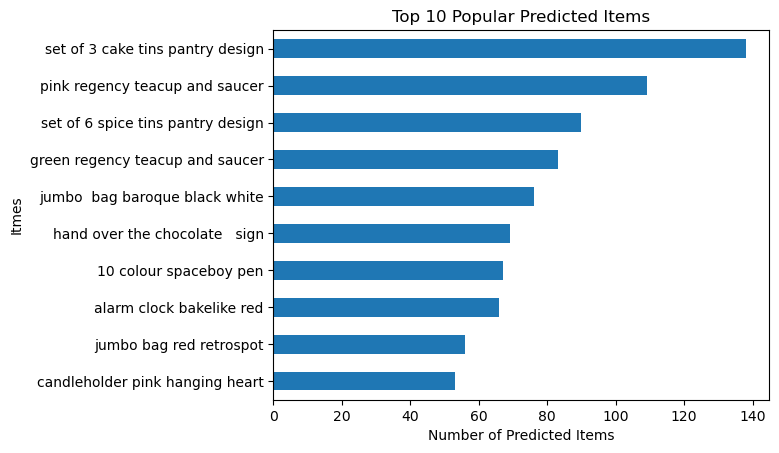

In [206]:
# Top 10 Popular Sold Items
df= result.groupby(["predicted_item"])["predicted_item"].count().sort_values(axis= 0,ascending =False)
df = df[:10,].sort_values(ascending = True)
df.plot(kind = "barh")
plt.ylabel('Itmes')
plt.xlabel('Number of Predicted Items')
plt.title('Top 10 Popular Predicted Items')

Time for generating recommendations using collaborative filtering: 61.60057497024536


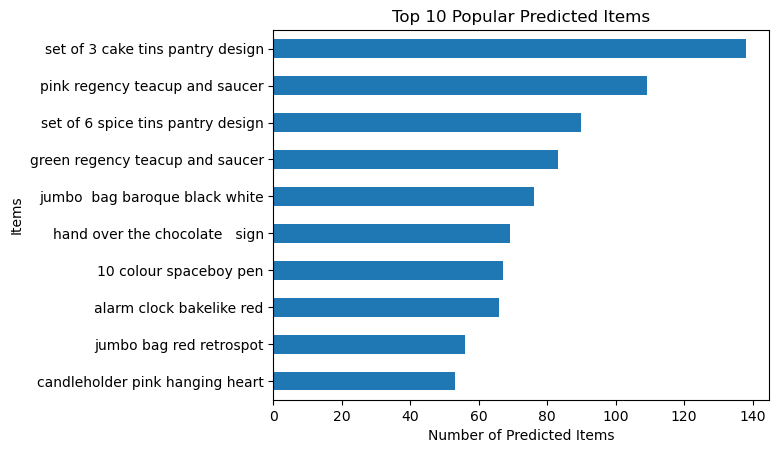

In [207]:
import time
import matplotlib.pyplot as plt

start_time_a = time.time()
new_test_data = test_data.reset_index(drop=True)
result_list = []

for i in range(len(new_test_data)):
    tmp = new_test_data.loc[i]
    item = tmp["Itemname"]
    res = get_recommandation(item, 1)
    result_list.append(pd.DataFrame(res))

result_new = pd.concat(result_list, ignore_index=True)

end_time_a = time.time()
cf_time = end_time_a - start_time_a
print("Time for generating recommendations using collaborative filtering: " + str(cf_time))

# Top 10 Popular Sold Items
df = result_new.groupby(["predicted_item"]).size().nlargest(10).sort_values(ascending=True)
df.plot(kind="barh")
plt.ylabel('Items')
plt.xlabel('Number of Predicted Items')
plt.title('Top 10 Popular Predicted Items')
plt.show()

In [208]:
sorted_data = result.sort_values(by='similarity', ascending=False)
sorted_data[:10]

,Itemname,predicted_item,similarity
7996,herb marker parsley,herb marker parsley,1.0
257,french wc sign blue metal,french bathroom sign blue metal,1.0
2384,party invites dinosaurs,party invites dinosaurs,1.0
3553,rose scent candle in jewelled box,rose scent candle in jewelled box,1.0
8301,french laundry sign blue metal,french bathroom sign blue metal,1.0
2932,alphabet hearts sticker sheet,panda and bunnies sticker sheet,1.0
70,herb marker mint,herb marker parsley,1.0
4051,ocean scent candle in jewelled box,rose scent candle in jewelled box,1.0
8316,french wc sign blue metal,french bathroom sign blue metal,1.0
3706,french blue metal door sign 4,french blue metal door sign 4,1.0


In [209]:
get_recommandation("10 colour spaceboy pen",10)

,Itemname,predicted_item,similarity
0,10 colour spaceboy pen,curious images gift wrap set,1.000000
1,10 colour spaceboy pen,birdcage decoration tealight holder,1.000000
2,10 colour spaceboy pen,pack of 12 pink polkadot tissues,1.000000
3,10 colour spaceboy pen,hearts wrapping tape,1.000000
4,10 colour spaceboy pen,pink love heart shape cup,1.000000
5,10 colour spaceboy pen,set/4 badges cute creatures,1.000000
6,10 colour spaceboy pen,set/4 badges balloon girl,1.000000
7,10 colour spaceboy pen,mini funky design tapes,1.000000
8,10 colour spaceboy pen,felt farm animal hen,1.000000
9,10 colour spaceboy pen,sleeping cat erasers,0.948683


In [210]:
get_recommandation("travel card wallet union jack",10)

,Itemname,predicted_item,similarity
0,travel card wallet union jack,travel card wallet keep calm,0.711512
1,travel card wallet union jack,travel card wallet suki,0.707107
2,travel card wallet union jack,travel card wallet skulls,0.670820
3,travel card wallet union jack,travel card wallet pantry,0.670820
4,travel card wallet union jack,black mini tape measure,0.670820
5,travel card wallet union jack,assorted tutti frutti notebook,0.632456
6,travel card wallet union jack,white spot blue ceramic drawer knob,0.632456
7,travel card wallet union jack,mini ladle love heart pink,0.632456
8,travel card wallet union jack,musical zinc heart decoration,0.632456
9,travel card wallet union jack,bathroom set love heart design,0.632456


In [211]:
get_recommandation("set of 6 spice tins pantry design", 10)

,Itemname,predicted_item,similarity
0,set of 6 spice tins pantry design,set of 3 cake tins pantry design,0.549491
1,set of 6 spice tins pantry design,set of 6 herb tins sketchbook,0.390212
2,set of 6 spice tins pantry design,pack of 12 traditional crayons,0.382255
3,set of 6 spice tins pantry design,pantry rolling pin,0.382255
4,set of 6 spice tins pantry design,traditional modelling clay,0.366397
5,set of 6 spice tins pantry design,pack of 12 coloured pencils,0.351123
6,set of 6 spice tins pantry design,wooden school colouring set,0.351123
7,set of 6 spice tins pantry design,jam making set with jars,0.347200
8,set of 6 spice tins pantry design,clothes pegs retrospot pack 24,0.332419
9,set of 6 spice tins pantry design,set 2 pantry design tea towels,0.327715


In [212]:
get_recommandation("pink regency teacup and saucer",10)

,Itemname,predicted_item,similarity
0,pink regency teacup and saucer,green regency teacup and saucer,0.787273
1,pink regency teacup and saucer,roses regency teacup and saucer,0.736850
2,pink regency teacup and saucer,regency cakestand 3 tier,0.397716
3,pink regency teacup and saucer,deluxe sewing kit,0.260290
4,pink regency teacup and saucer,button box,0.260290
5,pink regency teacup and saucer,feltcraft doll molly,0.257674
6,pink regency teacup and saucer,cake plate lovebird pink,0.255031
7,pink regency teacup and saucer,alarm clock bakelike red,0.250078
8,pink regency teacup and saucer,red retrospot small milk jug,0.233075
9,pink regency teacup and saucer,make your own flowerpower card kit,0.225417


In [213]:
get_recommandation("jumbo bag red retrospot",10)

,Itemname,predicted_item,similarity
0,jumbo bag red retrospot,jumbo bag baroque black white,0.482379
1,jumbo bag red retrospot,jumbo bag pink vintage paisley,0.473686
2,jumbo bag red retrospot,jumbo bag pink polkadot,0.417959
3,jumbo bag red retrospot,jumbo bag strawberry,0.406610
4,jumbo bag red retrospot,jumbo storage bag skulls,0.329690
5,jumbo bag red retrospot,red retrospot charlotte bag,0.328551
6,jumbo bag red retrospot,jumbo bag spaceboy design,0.321745
7,jumbo bag red retrospot,set/6 pink bird t-light candles,0.312772
8,jumbo bag red retrospot,retro coffee mugs assorted,0.312772
9,jumbo bag red retrospot,zinc heart lattice t-light holder,0.294884


### USER-BASED COLLABORATIVE FILTERING

In [214]:
train_rating_piv_df = pd.DataFrame(pd.pivot_table(train_rating, index='CustomerID', columns='Itemname', values='Rating'))
train_rating_piv_df.fillna(0, inplace=True)
train_rating_piv_df

Itemname,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 pencil small tube woodland,12 pencils small tube red retrospot,12 pencils small tube skull,12 pencils tall tube posy,...,yuletide images s/6 paper boxes,zinc finish 15cm planter pots,zinc heart lattice 2 wall planter,zinc heart lattice charger large,zinc heart lattice charger small,zinc heart lattice t-light holder,zinc heart lattice tray oval,zinc metal heart decoration,zinc top 2 door wooden shelf,zinc willie winkie candle stick
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12362,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18257,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18260,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [215]:
similarity_matrix_train_df = pd.DataFrame(cosine_similarity(train_rating_piv_df, train_rating_piv_df), index=train_rating_piv_df.index, columns=train_rating_piv_df.index)
similarity_matrix_train_df

CustomerID,12347,12350,12352,12356,12362,12370,12373,12377,12383,12386,...,18230,18233,18239,18245,18250,18257,18259,18260,18269,18283
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,1.000000,0.0,0.045644,0.00,0.000000,0.0,0.000000,0.339683,0.000000,0.0,...,0.0,0.0,0.026803,0.120386,0.043519,0.00000,0.0,0.036084,0.0,0.063541
12350,0.000000,1.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.000000
12352,0.045644,0.0,1.000000,0.00,0.000000,0.0,0.000000,0.062017,0.000000,0.0,...,0.0,0.0,0.058722,0.000000,0.190693,0.00000,0.0,0.079057,0.0,0.027842
12356,0.000000,0.0,0.000000,1.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.250000,0.0,0.000000
12362,0.000000,0.0,0.000000,0.00,1.000000,0.0,0.000000,0.147087,0.060634,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.0,0.000000,0.0,0.044023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18257,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.134840,0.059131,0.000000,0.0,...,0.0,0.0,0.000000,0.125739,0.090909,1.00000,0.0,0.000000,0.0,0.079640
18259,0.000000,0.0,0.000000,0.00,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.000000,0.000000,0.000000,0.00000,1.0,0.000000,0.0,0.000000
18260,0.036084,0.0,0.079057,0.25,0.000000,0.0,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.046424,0.104257,0.075378,0.00000,0.0,1.000000,0.0,0.022011


In [216]:
test_rating_piv_df = pd.DataFrame(pd.pivot_table(test_rating, index='CustomerID', columns='Itemname', values='Rating'))
test_rating_piv_df.fillna(0, inplace=True)
test_rating_piv_df

Itemname,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 pencil small tube woodland,12 pencils small tube red retrospot,12 pencils small tube skull,12 pencils tall tube red retrospot,...,yellow metal chicken heart,yellow shark helicopter,you're confusing me metal sign,zinc finish 15cm planter pots,zinc heart lattice charger large,zinc heart lattice charger small,zinc heart lattice t-light holder,zinc heart lattice tray oval,zinc metal heart decoration,zinc willie winkie candle stick
CustomerID,,,,,,,,,,,,,,,,,,,,,
12352.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12361.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12415.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12417.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12423.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18223.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18231.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [217]:
similarity_matrix_test_df = pd.DataFrame(cosine_similarity(test_rating_piv_df, test_rating_piv_df), index=test_rating_piv_df.index,
                                    columns=test_rating_piv_df.index)
similarity_matrix_test_df

CustomerID,12352.0,12361.0,12415.0,12417.0,12423.0,12431.0,12437.0,12458.0,12464.0,12471.0,...,18172.0,18188.0,18196.0,18198.0,18211.0,18218.0,18223.0,18231.0,18280.0,18283.0
CustomerID,,,,,,,,,,,,,,,,,,,,,
12352.0,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
12361.0,0.0,1.000000,0.0,0.000000,0.447214,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.084515
12415.0,0.0,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
12417.0,0.0,0.000000,0.0,1.000000,0.000000,0.113228,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.052414
12423.0,0.0,0.447214,0.0,0.000000,1.000000,0.000000,0.0,0.000000,0.000000,0.250000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.229416,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18218.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.081650,0.0,0.000000,0.0,0.000000,1.000000,0.093659,0.0,0.000000,0.077152
18223.0,0.0,0.000000,0.0,0.000000,0.229416,0.000000,0.0,0.000000,0.000000,0.114708,...,0.137649,0.0,0.161106,0.0,0.000000,0.093659,1.000000,0.0,0.145095,0.000000
18231.0,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000


In [218]:
def get_prediction(userid, itemname, sim_rating, rating):
    user_rating = rating.loc[:,itemname]
    user_similarity = sim_rating.sort_values(by=userid, ascending=False).loc[:, userid].tolist()
    weighted_sum = np.dot(user_similarity, user_rating)
    weighted_sum /= np.sum(user_similarity)
    return weighted_sum

In [219]:
prediction = []
train_real = train_rating['Rating'].to_numpy()
for _,row in train_rating.iterrows():
    result = get_prediction(row[0], row[1], similarity_matrix_train_df, train_rating_piv_df)
    prediction.append(result)
rmse = np.sqrt(np.mean((train_real - prediction)**2))
print(f'Train data RMSE = {rmse}')

Train data RMSE = 1.2453348077286899


In [220]:
prediction = []
test_real = test_rating['Rating'].to_numpy()
for _,row in test_rating.iterrows():
    result = get_prediction(row[0], row[1], similarity_matrix_test_df, test_rating_piv_df)
    prediction.append(result)
rmse = np.sqrt(np.mean((test_real - prediction)**2))
print(f'Test data RMSE = {rmse}')

Test data RMSE = 1.0417814936185092


### Matrix Factorization using ALS -Small dataset

In [221]:
dataset_mf = dataset.copy()

In [222]:
items_per_customer_df = (dataset_mf.groupby(["CustomerID"]).agg({"Itemname": "nunique"}).reset_index())

In [223]:
items_per_customer_df.columns = ["CustomerID", "Count_item_cust"]
items_per_customer_df

,CustomerID,Count_item_cust
0,12347.0,24
1,12350.0,2
2,12352.0,12
3,12356.0,1
4,12361.0,5
...,...,...
1655,18259.0,3
1656,18260.0,16
1657,18269.0,5
1658,18280.0,10


In [224]:
# Filtering Results
mask = items_per_customer_df["Count_item_cust"] >= 6
valid_customer = set(items_per_customer_df.loc[mask, "CustomerID"].tolist())
df_filter_cust = dataset[dataset["CustomerID"].isin(valid_customer)].copy()
billno_filter_cust = set(df_filter_cust["BillNo"].tolist())

In [225]:
# Calculate count of unique customers per item
custs_per_item_df = dataset.groupby(["Itemname"]).agg({"CustomerID": "nunique"}).reset_index()
custs_per_item_df.columns = ["Itemname", "Count_cust_item"]

# Count the occurrences of each unique count of customers per item
counts_per_item = custs_per_item_df["Count_cust_item"].value_counts()
counts_per_item

Count_cust_item
1      396
2      255
3      221
4      157
6      123
      ... 
170      1
152      1
96       1
123      1
89       1
Name: count, Length: 125, dtype: int64

In [226]:
cust_in_item_threshold = 6

In [227]:
# Filter Results
mask = custs_per_item_df["Count_cust_item"] >= cust_in_item_threshold
valid_billnos = set(custs_per_item_df.loc[mask, "Itemname"].tolist())


In [228]:
# Filtering items based on valid stock codes
df_filter_item = dataset[dataset["Itemname"].isin(valid_billnos)].copy()
billnos_filter_item = set(df_filter_item["BillNo"].tolist())

# Finding the intersection of bill numbers
billnos_intersect = set.intersection(billnos_filter_item, billno_filter_cust)

# Printing the counts
print(f"No. of invoices after filtering by customer: {len(billno_filter_cust)}")
print(f"No. of invoices after filtering by item: {len(billnos_filter_item)}")
print(f"No. of invoices from intersection: {len(billnos_intersect)}")


No. of invoices after filtering by customer: 2727
No. of invoices after filtering by item: 3099
No. of invoices from intersection: 2714


In [229]:
df_filter_cust_item = dataset[dataset["BillNo"].isin(billnos_intersect)].copy()

In [230]:
df_filter_cust_item.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47925 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   BillNo      47925 non-null  float64       
 1   Itemname    47925 non-null  object        
 2   Quantity    47925 non-null  float64       
 3   Date        47925 non-null  datetime64[ns]
 4   Price       47925 non-null  float64       
 5   CustomerID  47925 non-null  float64       
 6   cost        47925 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(1)
memory usage: 2.9+ MB


In [231]:
unique_customers_filter = df_filter_cust_item["CustomerID"].unique()
customer_ids = dict(zip(unique_customers_filter, np.arange(unique_customers_filter.shape[0], dtype=np.int32)))

In [232]:
unique_items_filter = df_filter_cust_item["Itemname"].unique()
item_ids_filter = dict(zip(unique_items_filter, np.arange(unique_items_filter.shape[0], dtype=np.int32)))

In [233]:
df_filter_cust_item["customer_id"] = df_filter_cust_item["CustomerID"].apply(lambda i: customer_ids[i])
df_filter_cust_item["item_id"] = df_filter_cust_item["Itemname"].apply(lambda i: item_ids_filter[i])

In [234]:
print(f"{len(customer_ids)}, {len(item_ids_filter)}")

1310, 2619


In [235]:
df_filter_cust_item.sort_values(by=["Itemname"], inplace=True)
df_filter_cust_item.head(10)

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost,customer_id,item_id
17683,539663.0,10 colour spaceboy pen,1.0,2010-12-21 10:26:00,0.85,17961.0,0.85,125,787
1696,536643.0,10 colour spaceboy pen,2.0,2010-12-02 11:57:00,0.85,14390.0,1.70,79,787
3291,536993.0,10 colour spaceboy pen,2.0,2010-12-03 15:19:00,0.85,14396.0,1.70,153,787
8501,537781.0,10 colour spaceboy pen,2.0,2010-12-08 12:46:00,0.85,17341.0,1.70,342,787
7415,545658.0,10 colour spaceboy pen,5.0,2011-03-04 14:13:00,0.85,14670.0,4.25,1263,787
22272,540813.0,12 coloured party balloons,10.0,2011-01-11 12:41:00,0.65,14669.0,6.50,744,858
6219,537366.0,12 coloured party balloons,10.0,2010-12-06 12:39:00,0.65,14085.0,6.50,249,858
27081,541832.0,12 coloured party balloons,10.0,2011-01-21 17:14:00,0.65,17889.0,6.50,852,858
26634,541684.0,12 coloured party balloons,10.0,2011-01-20 15:22:00,0.65,15498.0,6.50,338,858
4362,537138.0,12 coloured party balloons,6.0,2010-12-05 12:44:00,0.65,17211.0,3.90,188,858


In [236]:
df_cust_item_qty = df_filter_cust_item.groupby(["customer_id", "item_id"])["Quantity"].sum().reset_index()

In [237]:
df_cust_item_qty.head()

,customer_id,item_id,Quantity
0,0,0,98.0
1,0,1,92.0
2,0,2,86.0
3,0,3,104.0
4,0,4,42.0


In [238]:
sparse_customer_item = sparse.csr_matrix((df_cust_item_qty["Quantity"].astype(float), (df_cust_item_qty["customer_id"], df_cust_item_qty["item_id"])))

In [239]:
model = implicit.als.AlternatingLeastSquares(num_threads=1)
model.fit(sparse_customer_item)

  0%|          | 0/15 [00:00<?, ?it/s]

In [240]:
item_vecs = model.item_factors
customer_vecs = model.user_factors

In [241]:
ref_item_id = df_filter_cust_item["item_id"].unique()

# Check the type of ref_item_id
print(type(ref_item_id))

<class 'numpy.ndarray'>


In [242]:
similar_items, scores = model.similar_items(ref_item_id, N=10)
# Create a DataFrame from similar_items
df_similar_items = pd.DataFrame(similar_items)
# Add a column for the reference item ID
df_similar_items["Ref Item ID"] = ref_item_id
# Display the first few rows of the DataFrame
print(df_similar_items.head())

      0     1     2     3     4     5     6     7     8     9  Ref Item ID
0   787  1037   387  1682  2275  2162  1517  1845   479  2514          787
1   858  2340  1306  2593  2594  2314  2289  1219  1201  1005          858
2   248  2608  1523  1981   264  1037  1798  1040  1902  2477          248
3  2113   830  1350  1698  1887   692   634   576  2251  1352         2113
4  1215   841  1817  2397  2301  2302  1317  1431  1744   807         1215


In [243]:
df_item_rank = pd.melt(df_similar_items.rename(columns={"Ref Item ID": "Ref_Item_ID"}), id_vars=["Ref_Item_ID"], var_name=["Item Rank"], value_name="Related Item ID")

In [244]:
df_item_rank_sorted = df_item_rank.sort_values(by=["Related Item ID", "Item Rank"]).head(20)
df_item_rank_sorted

,Ref_Item_ID,Item Rank,Related Item ID
1254,0,0,0
9027,116,3,0
12511,118,4,0
13627,112,5,0
20256,3,7,0
1010,1,0,1
6247,2353,2,1
12763,991,4,1
16824,89,6,1
2528,2,0,2


In [245]:
df_score_rank = pd.DataFrame(scores).assign(Ref_Item_ID=ref_item_id).melt(id_vars=["Ref_Item_ID"], var_name=["Item Rank"], value_name="Score").sort_values(["Ref_Item_ID", "Item Rank"]).head(20)
df_score_rank

,Ref_Item_ID,Item Rank,Score
1254,0,0,1.000000
3873,0,1,0.454005
6492,0,2,0.453551
9111,0,3,0.447574
11730,0,4,0.446542
14349,0,5,0.444738
16968,0,6,0.444596
19587,0,7,0.423268
22206,0,8,0.422461
24825,0,9,0.422115


In [246]:
df_item_score = df_item_rank.merge(df_score_rank, how="inner", on=["Ref_Item_ID", "Item Rank"]).sort_values(["Ref_Item_ID", "Item Rank"]).head(20)
df_item_score

,Ref_Item_ID,Item Rank,Related Item ID,Score
1,0,0,0,1.000000
3,0,1,2264,0.454005
5,0,2,2261,0.453551
7,0,3,118,0.447574
9,0,4,2262,0.446542
11,0,5,875,0.444738
13,0,6,168,0.444596
15,0,7,2465,0.423268
17,0,8,2466,0.422461
19,0,9,3,0.422115


In [247]:
df_item_desc = df_filter_cust_item[["item_id", "Itemname"]].drop_duplicates(subset=["item_id"])

In [248]:
df_similar_item_temp = df_item_score.merge(df_item_desc, how="left", left_on="Ref_Item_ID", right_on="item_id")

In [249]:
df_similar_item_temp.drop(columns=["item_id"], inplace=True)
df_similar_item_temp.columns = [
    "Ref Item ID",
    "Item Rank",
    "Related Item ID",
    "Score",
    "Ref_BillNO",
]

In [250]:
df_similar_item_temp.shape
df_similar_item_temp.head()

,Ref Item ID,Item Rank,Related Item ID,Score,Ref_BillNO
0,0,0,0,1.000000,knitted union flag hot water bottle
1,0,1,2264,0.454005,knitted union flag hot water bottle
2,0,2,2261,0.453551,knitted union flag hot water bottle
3,0,3,118,0.447574,knitted union flag hot water bottle
4,0,4,2262,0.446542,knitted union flag hot water bottle


In [251]:
df_similar_item_final = df_similar_item_temp.merge(df_item_desc, how="left", left_on="Related Item ID", right_on="item_id")
df_similar_item_final.drop(columns=["item_id"], inplace=True)
df_similar_item_final.columns = [
    "Ref Item ID",
    "Item Rank",
    "Related Item ID",
    "Score",
    "Ref_BillNO",
    "Related_BillNO",
]
df_similar_item_final.head()

,Ref Item ID,Item Rank,Related Item ID,Score,Ref_BillNO,Related_BillNO
0,0,0,0,1.000000,knitted union flag hot water bottle,knitted union flag hot water bottle
1,0,1,2264,0.454005,knitted union flag hot water bottle,red acrylic faceted bangle
2,0,2,2261,0.453551,knitted union flag hot water bottle,black/white glass/silver bracelet
3,0,3,118,0.447574,knitted union flag hot water bottle,scottie dog hot water bottle
4,0,4,2262,0.446542,knitted union flag hot water bottle,grey acrylic faceted bangle


In [252]:
df_cust_id_map = df_filter_cust_item[["CustomerID", "customer_id"]].drop_duplicates(subset="customer_id")

In [253]:
df_cust_id_map.head(20)

,CustomerID,customer_id
17683,17961.0,125
1696,14390.0,79
3291,14396.0,153
8501,17341.0,342
7415,14670.0,1263
22272,14669.0,744
6219,14085.0,249
27081,17889.0,852
26634,15498.0,338
4362,17211.0,188


In [254]:
CustomerID = 16714
cust_id = df_cust_id_map[df_cust_id_map["CustomerID"] == CustomerID]["customer_id"].item()
print(cust_id)

908


In [255]:
df_filter_cust_item[df_filter_cust_item["customer_id"] == cust_id]

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost,customer_id,item_id
29393,542231.0,12 coloured party balloons,10.0,2011-01-26 13:40:00,0.65,16714.0,6.50,908,858
29347,542231.0,3d hearts honeycomb paper garland,6.0,2011-01-26 13:40:00,2.95,16714.0,17.70,908,2349
29379,542231.0,alarm clock bakelike green,2.0,2011-01-26 13:40:00,3.75,16714.0,7.50,908,76
29348,542231.0,alarm clock bakelike red,2.0,2011-01-26 13:40:00,3.75,16714.0,7.50,908,103
29354,542231.0,alphabet hearts sticker sheet,3.0,2011-01-26 13:40:00,0.85,16714.0,2.55,908,1338
...,...,...,...,...,...,...,...,...,...
29389,542231.0,toast its - i love you,1.0,2011-01-26 13:40:00,1.25,16714.0,1.25,908,1230
29344,542231.0,vintage red kitchen cabinet,2.0,2011-01-26 13:40:00,125.00,16714.0,250.00,908,1920
29409,542231.0,white hanging heart t-light holder,6.0,2011-01-26 13:40:00,2.95,16714.0,17.70,908,2
29385,542231.0,wood stamp set thank you,4.0,2011-01-26 13:40:00,1.65,16714.0,6.60,908,1246


In [256]:
ids, scores = model.recommend(cust_id, sparse_customer_item[cust_id], N=20, filter_already_liked_items=False)
list_billno = df_item_desc[df_item_desc["item_id"].isin(ids)]["Itemname"].tolist()
df_recommendations = pd.DataFrame(
    {
        "BillNo": list_billno,
        "score": scores,
        "already_liked": np.in1d(ids, sparse_customer_item[cust_id].indices),
    }
)
df_recommendations

,BillNo,score,already_liked
0,12 coloured party balloons,1.057757,True
1,assorted colour bird ornament,1.037455,True
2,baking mould heart white chocolate,1.033567,True
3,coffee mug apples design,1.024747,True
4,coffee mug pears design,1.023202,True
5,doormat hearts,1.019864,True
6,feltcraft 6 flower friends,1.009014,True
7,feltcraft butterfly hearts,0.990145,True
8,happy stencil craft,0.975280,True
9,jam making set with jars,0.972309,True


In [257]:
def get_prediction(model):
    predictions = []
    for customer_id in df_cust_id_map['customer_id']:
        filtered_df = df_filter_cust_item[df_filter_cust_item["customer_id"] == customer_id]
        ids, scores = model.recommend(customer_id, sparse_customer_item[customer_id], N=20, filter_already_liked_items=False)
        list_billno = df_item_desc[df_item_desc["item_id"].isin(ids)]["Itemname"].tolist()
        df_recommendations = pd.DataFrame({
            "customer_id": customer_id,
            "BillNO": list_billno,
            "score": scores,
            "already_liked": np.in1d(ids, sparse_customer_item[customer_id].indices),
        })
        predictions.append(df_recommendations)

    return pd.concat(predictions, ignore_index=True)

predictions = get_prediction(model)

In [258]:
predictions.head(50)

,customer_id,BillNO,score,already_liked
0,125,36 pencils tube skulls,1.159593,True
1,125,aged glass silver t-light holder,1.023575,True
2,125,baking mould chocolate cupcakes,0.899296,True
3,125,blue polkadot cup,0.863813,True
4,125,blue polkadot plate,0.835371,True
5,125,childs breakfast set dolly girl,0.783635,True
6,125,childs breakfast set spaceboy,0.752133,True
7,125,cinammon set of 9 t-lights,0.751351,True
8,125,family photo frame cornice,0.740699,True
9,125,grand chocolatecandle,0.733639,True


In [259]:
def make_train(ratings, pct_test=0.2):
    # Make a copy of the original set to be the test set
    test_set = ratings.copy()
    # Store the test set as a binary preference matrix
    test_set[test_set != 0] = 1

    # Make a copy of the original data we can alter as our training set
    training_set = ratings.copy()

    # Find the indices in the ratings data where an interaction exists
    nonzero_inds = training_set.nonzero()
    # Zip these pairs together of item,user index into list
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))

    # Set the random seed for reproducibility
    random.seed(0)

    # Round the number of samples needed to the nearest integer
    num_samples = int(np.ceil(pct_test * len(nonzero_pairs)))
    # Sample a random number of item-user pairs without replacement
    samples = random.sample(nonzero_pairs, num_samples)

    # Get the item row indices
    item_inds = [index[0] for index in samples]
    # Get the user column indices
    customer_inds = [index[1] for index in samples]

    # Assign all of the randomly chosen user-item pairs to zero
    training_set[item_inds, customer_inds] = 0
    # Get rid of zeros in sparse array storage after update to save space
    training_set = csr_matrix(training_set)

    return training_set, test_set, list(set(customer_inds))

item_train, item_test, item_customers_altered = make_train(sparse_customer_item, pct_test=0.2)


In [260]:
def auc_score(predictions, test):
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [261]:
import numpy as np
from sklearn.metrics import f1_score, recall_score


def calc_mean_auc(training_set, altered_customers, predictions, test_set):
    store_auc = []  # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = []  # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis=1)).reshape(-1)  # Get sum of item interactions to find most popular
    customer_vecs, item_vecs = predictions
    num_users, num_features = customer_vecs.shape
    predicted_list = []
    actual_list = []
    squared_errors = []  # List to store squared errors for RMSE calculation
    for customer in altered_customers:  # Iterate through each user that had an item altered
        if customer >= num_users:
            # If the index of the altered customer exceeds the number of users, skip
            continue

        training_column = training_set[:, customer].toarray().reshape(-1)  # Get the training set column
        zero_inds = np.where(training_column == 0)[0]  # Find where the interaction had not yet occurred

        # Get the predicted values based on our user/item vectors
        customer_vec = customer_vecs[customer, :]
        pred = np.dot(customer_vec.reshape(1, -1), item_vecs).flatten()[zero_inds]

        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no interaction
        actual = test_set[:, customer].toarray()[zero_inds, 0].reshape(-1)
        actual_list.append(actual)
        predicted_list.append(pred)
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training
        pop = pop_items[zero_inds]  # Get the item popularity for our chosen items

        # Calculate AUC for the given user and store
        store_auc.append(auc_score(pred, actual))
        # Calculate AUC using most popular and store
        popularity_auc.append(auc_score(pop, actual))

        # Calculate squared errors for RMSE calculation
        squared_errors.extend(np.square(actual - pred))

    # Calculate F1 score and recall
    predicted = np.concatenate(predicted_list)
    actual = np.concatenate(actual_list)
    f1 = f1_score(actual, predicted.round(), average='macro')
    recall = recall_score(actual, predicted.round(), average='macro')

    # Calculate Mean Reciprocal Rank (MRR)
    reciprocal_ranks = np.array([1.0 / (np.where(np.argsort(pred)[::-1] == np.where(actual == 1)[0][0])[0][0] + 1)
                                 for pred, actual in zip(predicted_list, actual_list) if len(np.where(actual == 1)[0]) > 0])
    mrr = np.mean(reciprocal_ranks)

    # Calculate RMSE
    rmse = np.sqrt(np.mean(squared_errors))

    return float('%.3f' % np.mean(store_auc)), float('%.3f' % np.mean(popularity_auc)), f1, recall, mrr, rmse

# Call the function
calc_mean_auc(item_train, item_customers_altered,
              [customer_vecs, item_vecs.T], item_test)


(0.511,
 0.776,
 0.24981512338657583,
 0.2515003693797029,
 0.011770858196089473,
 0.15473648333577517)

### BIG DATA SET

In [262]:
train_data=pd.read_csv("basket_data_by_date_train_big.csv")
test_data=pd.read_csv("basket_data_by_date_test_big.csv")

In [263]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   BillNo      200000 non-null  int64  
 1   Itemname    200000 non-null  object 
 2   Quantity    200000 non-null  int64  
 3   Date        200000 non-null  object 
 4   Price       200000 non-null  float64
 5   CustomerID  200000 non-null  int64  
 6   cost        200000 non-null  float64
dtypes: float64(2), int64(3), object(2)
memory usage: 10.7+ MB


In [264]:
train_data.describe()

,BillNo,Quantity,Price,CustomerID,cost
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,555444.533915,3.720960,3.609832,15461.086845,11.227514
std,10778.632198,2.763365,4.928895,1687.747367,11.995236
min,536365.000000,1.000000,0.060000,12347.000000,0.100000
25%,546084.000000,1.000000,1.650000,14096.000000,3.300000
50%,555653.000000,3.000000,2.550000,15464.000000,8.400000
75%,565324.000000,6.000000,4.250000,16931.000000,16.500000
max,572741.000000,10.000000,295.000000,18287.000000,527.700000


- **Quantity:** On average, each transaction involves buying around 3 to 4 items. The transactions range is from 1 to 10.
- **Price:** The cheapest item costs just `$0.1`, while the most expensive one is `$295.00`.
- **CustomerID:** The lowest customer number is 12347, and the highest is 18283.
- **Cost:** The smallest transaction costs just `$0.14`., while the largest one is `$527.7`.

In [265]:
train_data.head(5)

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,536365,KNITTED UNION FLAG HOT WATER BOTTLE,6,1/12/2010 8:26,3.39,17850,20.34
1,536365,GLASS STAR FROSTED T-LIGHT HOLDER,6,1/12/2010 8:26,4.25,17850,25.50
2,536365,WHITE HANGING HEART T-LIGHT HOLDER,6,1/12/2010 8:26,2.55,17850,15.30
3,536365,RED WOOLLY HOTTIE WHITE HEART.,6,1/12/2010 8:26,3.39,17850,20.34
4,536365,SET 7 BABUSHKA NESTING BOXES,2,1/12/2010 8:26,7.65,17850,15.30


In [266]:
train_data.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

In [267]:
test_data.describe()

,BillNo,Quantity,Price,CustomerID,cost
count,65326.000000,65326.000000,65326.000000,65326.000000,65326.000000
mean,577106.526743,3.354116,3.144051,15453.535300,9.233652
std,2497.493577,2.634817,3.423463,1681.188085,10.541928
min,572741.000000,1.000000,0.060000,12347.000000,0.060000
25%,574898.000000,1.000000,1.250000,14096.000000,2.500000
50%,577086.500000,2.000000,2.080000,15453.000000,5.850000
75%,579142.000000,5.000000,3.950000,16929.000000,14.850000
max,581587.000000,10.000000,165.000000,18283.000000,510.000000


For the test data:
- **Quantity:** On average, each transaction involves buying around 3.67 items. The transactions range is from 1 to 10.
- **Price:** The cheapest item costs just `$0.10`, while the most expensive one is `$195.00`.
- **CustomerID:** The lowest customer number is 12352, and the highest is 18283.
- **Cost:** The smallest transaction costs just `$0.19` , while the largest one is `$290.00`.

In [268]:
test_data.head(5)

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost
0,572741,CHRISTMAS CRAFT LITTLE FRIENDS,6,25/10/2011 15:47,2.10,14341,12.60
1,572741,BISCUIT TIN 50'S CHRISTMAS,6,25/10/2011 15:47,2.89,14341,17.34
2,572741,CHRISTMAS CRAFT TREE TOP ANGEL,6,25/10/2011 15:47,2.10,14341,12.60
3,572741,ROTATING SILVER ANGELS T-LIGHT HLDR,6,25/10/2011 15:47,2.55,14341,15.30
4,572741,PAPER CHAIN KIT 50'S CHRISTMAS,6,25/10/2011 15:47,2.95,14341,17.70


In [269]:
#removing any rows containing missing values (NaN)
test_data = test_data.dropna()

In [270]:
#checking null values in test dataset
test_data.isnull().sum()

BillNo        0
Itemname      0
Quantity      0
Date          0
Price         0
CustomerID    0
cost          0
dtype: int64

In [271]:
# Checking for duplicate rows
train_data.duplicated().sum()

3198

In [272]:
# Checking for duplicate rows
test_data.duplicated().sum()

1688

In [273]:
# Removing duplicate rows
train_data = train_data.drop_duplicates()
test_data = test_data.drop_duplicates()

In [274]:
#Lowering all text
train_data=train_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)
test_data=test_data.applymap(lambda x: x.lower() if isinstance(x, str) else x)

In [275]:
format_string = "%d/%m/%Y %H:%M"
# Converting 'Date' column to datetime objects
train_data['Date'] = pd.to_datetime(train_data['Date'], format=format_string)
test_data['Date'] = pd.to_datetime(test_data['Date'], format=format_string)

In [276]:
#Merging to plot graphs
dataset = pd.concat([train_data, test_data])

In [277]:
item_count= dataset.groupby(["Itemname"]).count()
item_count

,BillNo,Quantity,Date,Price,CustomerID,cost
Itemname,,,,,,
10 colour spaceboy pen,22,22,22,22,22,22
12 coloured party balloons,77,77,77,77,77,77
12 daisy pegs in wood box,49,49,49,49,49,49
12 egg house painted wood,57,57,57,57,57,57
12 hanging eggs hand painted,8,8,8,8,8,8
...,...,...,...,...,...,...
zinc t-light holder stars small,39,39,39,39,39,39
zinc top 2 door wooden shelf,9,9,9,9,9,9
zinc willie winkie candle stick,51,51,51,51,51,51


Text(0.5, 1.0, 'Top 10 Popular Sold Items')

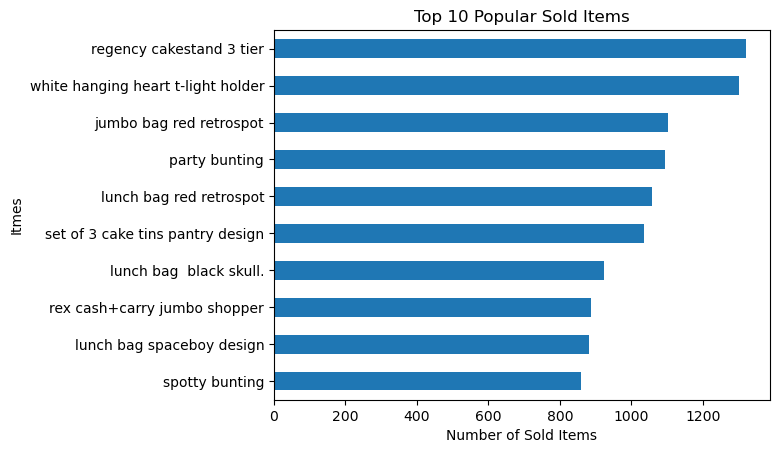

In [278]:
# Top 10 Popular Sold Items
df= dataset.groupby(["Itemname"])["Quantity"].count().sort_values(axis= 0,ascending =False)
df = df[:10,].sort_values(ascending = True)
df.plot(kind = "barh")
plt.ylabel('Itmes')
plt.xlabel('Number of Sold Items')
plt.title('Top 10 Popular Sold Items')

In [279]:
df = dataset.groupby("CustomerID")["CustomerID"].count()
df

CustomerID
12347     83
12349     45
12350      2
12352     51
12353      4
        ... 
18280     10
18281      4
18282     10
18283    713
18287     10
Name: CustomerID, Length: 4048, dtype: int64

In [280]:
df = dataset.groupby("CustomerID")["CustomerID"].count().nlargest(10)
df

CustomerID
17841    7324
14096    4865
12748    3877
14606    2592
15311    1812
13263    1610
15039    1301
18118    1238
14159    1115
16033    1086
Name: CustomerID, dtype: int64

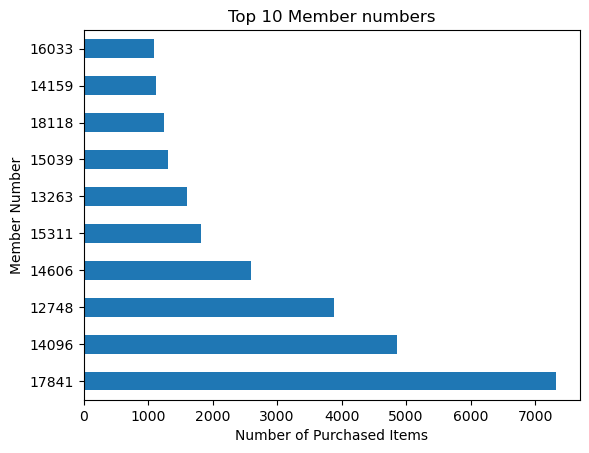

In [281]:
df = dataset.groupby("CustomerID")["CustomerID"].count().nlargest(10)
# Plot the top 10 member numbers
df.plot(kind="barh")
plt.ylabel('Member Number')
plt.xlabel('Number of Purchased Items')
plt.title('Top 10 Member numbers')
plt.show()

In [282]:
dataset[dataset['Quantity'] < 1]

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost


In [283]:
zero_price_count = len(dataset[dataset['cost'] == 0])
print("Number of rows where price is zero:", zero_price_count)
# Counting the number of rows where the price is negative
negative_price_count = len(dataset[dataset['cost'] < 0])
print("Number of rows where price is negative:", negative_price_count)

Number of rows where price is zero: 0
Number of rows where price is negative: 0


Month
2010-12    189586.78
Name: cost, dtype: float64
Month
2011-01    163000.93
2011-02    149459.02
2011-03    197714.81
2011-04    168465.96
2011-05    234590.84
2011-06    202322.56
2011-07    185897.16
2011-08    193723.02
2011-09    284037.29
2011-10    339640.31
2011-11    415233.64
2011-12    106925.05
Name: cost, dtype: float64


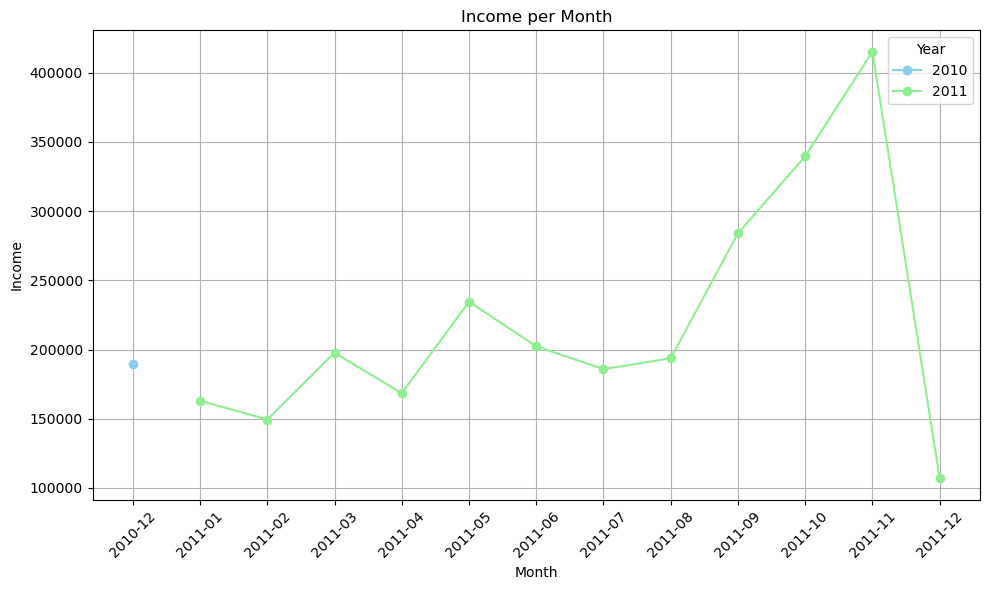

In [284]:
def plot_income_per_month(data, years, colors):
    plt.figure(figsize=(10, 6))

    for year, color in zip(years, colors):
        df_year = data[data['Date'].dt.year == year]
        df_year['Month'] = df_year['Date'].dt.strftime('%Y-%m')
        monthly_income = df_year.groupby('Month')['cost'].sum()
        print(monthly_income)
        plt.plot(monthly_income.index, monthly_income.values, marker='o', color=color, label=str(year))

    plt.title('Income per Month')
    plt.xlabel('Month')
    plt.ylabel('Income')
    plt.xticks(rotation=45)
    plt.legend(title='Year')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage
years = [2010, 2011]
colors = ['skyblue', 'lightgreen']
plot_income_per_month(dataset, years, colors)

In [285]:
train_df=train_data.copy()
test_df = test_data.copy()

In [286]:
train_rating_df = pd.DataFrame(columns=["CustomerID", "Itemname", "Rating"])

for i in range(len(train_df)):
    customer_id = train_df.iloc[i]["CustomerID"]
    item_name = train_df.iloc[i]["Itemname"]
    temp = train_df.loc[(train_df["CustomerID"] == customer_id) & (train_df["Itemname"] == item_name)]
    create_row = {"CustomerID": customer_id, "Itemname": item_name, "Rating": len(temp)}
    train_rating_df = pd.concat([train_rating_df, pd.DataFrame([create_row])], ignore_index=True)

In [287]:
test_rating_df = pd.DataFrame(columns=["CustomerID", "Itemname", "Rating"])

for i in range(len(test_df)):
    customer_id = test_df.iloc[i]["CustomerID"]
    item_name = test_df.iloc[i]["Itemname"]
    temp = test_df.loc[(test_df["CustomerID"] == customer_id) & (test_df["Itemname"] == item_name)]
    create_row = {"CustomerID": customer_id, "Itemname": item_name, "Rating": len(temp)}
    test_rating_df = pd.concat([test_rating_df, pd.DataFrame([create_row])], ignore_index=True)

In [288]:
#droping duplicates
train_rating = train_rating_df.drop_duplicates()
test_rating = test_rating_df.drop_duplicates()

In [289]:
unique_customer_count = dataset['CustomerID'].unique()
unique_items_count = dataset['Itemname'].unique()

In [290]:
print("Total customer count:", len(unique_customer_count))
print("Total items count:", len(unique_items_count))

Total customer count: 4048
Total items count: 3680


In [291]:
train_rating_piv_df = pd.DataFrame(pd.pivot_table(train_rating, index='Itemname', columns='CustomerID', values='Rating'))
train_rating_piv_df.fillna(0, inplace=True)

In [292]:
train_rating_piv_df

CustomerID,12347,12350,12352,12353,12354,12355,12356,12358,12360,12361,...,18269,18270,18272,18277,18278,18280,18281,18282,18283,18287
Itemname,,,,,,,,,,,,,,,,,,,,,
10 colour spaceboy pen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12 coloured party balloons,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 daisy pegs in wood box,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 egg house painted wood,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12 ivory rose peg place settings,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zinc t-light holder stars small,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zinc top 2 door wooden shelf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zinc willie winkie candle stick,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [293]:
similarity_matrix_train_df = pd.DataFrame(cosine_similarity(train_rating_piv_df, train_rating_piv_df), index=train_rating_piv_df.index, columns=train_rating_piv_df.index)
similarity_matrix_train_df

Itemname,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 pencil small tube woodland,12 pencils small tube red retrospot,12 pencils small tube skull,12 pencils tall tube posy,...,zinc plant pot holder,zinc star t-light holder,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
Itemname,,,,,,,,,,,,,,,,,,,,,
10 colour spaceboy pen,1.000000,0.109322,0.049663,0.000000,0.000000,0.026304,0.162069,0.000000,0.031235,0.045294,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.220863,0.000000,0.000000
12 coloured party balloons,0.109322,1.000000,0.063600,0.000000,0.064169,0.101058,0.163075,0.053666,0.120000,0.019335,...,0.0,0.0,0.000000,0.083075,0.054772,0.000000,0.000000,0.035355,0.000000,0.000000
12 daisy pegs in wood box,0.049663,0.063600,1.000000,0.041013,0.106887,0.071414,0.149287,0.161175,0.219066,0.071732,...,0.0,0.0,0.063920,0.075479,0.174175,0.191413,0.000000,0.000000,0.000000,0.058798
12 egg house painted wood,0.000000,0.000000,0.041013,1.000000,0.106404,0.019550,0.022944,0.027685,0.046429,0.000000,...,0.0,0.0,0.046663,0.018367,0.113024,0.130420,0.109435,0.102595,0.000000,0.042924
12 ivory rose peg place settings,0.000000,0.064169,0.106887,0.106404,1.000000,0.200720,0.095130,0.106590,0.177228,0.017724,...,0.0,0.0,0.055279,0.054396,0.133892,0.154501,0.097231,0.453743,0.000000,0.050849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zinc t-light holder stars small,0.000000,0.000000,0.191413,0.130420,0.154501,0.091245,0.017847,0.032303,0.128412,0.034914,...,0.0,0.0,0.254084,0.142872,0.769277,1.000000,0.042563,0.000000,0.000000,0.267112
zinc top 2 door wooden shelf,0.000000,0.000000,0.000000,0.109435,0.097231,0.000000,0.052414,0.031623,0.047140,0.068359,...,0.0,0.0,0.000000,0.000000,0.000000,0.042563,1.000000,0.187500,0.000000,0.000000
zinc willie winkie candle stick,0.220863,0.035355,0.000000,0.102595,0.453743,0.029775,0.072070,0.047434,0.035355,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.187500,1.000000,0.000000,0.000000


In [294]:
test_rating_piv_df = pd.DataFrame(pd.pivot_table(test_rating, index='Itemname', columns='CustomerID', values='Rating'))
test_rating_piv_df.fillna(0, inplace=True)

similarity_matrix_test_df = pd.DataFrame(cosine_similarity(test_rating_piv_df, test_rating_piv_df), index=test_rating_piv_df.index,
                                    columns=test_rating_piv_df.index)
similarity_matrix_test_df

Itemname,10 colour spaceboy pen,12 coloured party balloons,12 egg house painted wood,12 hanging eggs hand painted,12 message cards with envelopes,12 pencil small tube woodland,12 pencils small tube red retrospot,12 pencils small tube skull,12 pencils tall tube red retrospot,12 pencils tall tube skulls,...,zinc herb garden container,zinc metal heart decoration,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
Itemname,,,,,,,,,,,,,,,,,,,,,
10 colour spaceboy pen,1.000000,0.458831,0.353553,0.000000,0.000000,0.404226,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.189832,0.000000,0.235702,0.554700,0.730297,0.0,0.654654,0.000000,0.000000
12 coloured party balloons,0.458831,1.000000,0.162221,0.072548,0.000000,0.241113,0.072954,0.079872,0.136797,0.000000,...,0.000000,0.108876,0.000000,0.108148,0.254514,0.335083,0.0,0.300376,0.000000,0.000000
12 egg house painted wood,0.353553,0.162221,1.000000,0.000000,0.000000,0.314414,0.224860,0.123091,0.000000,0.267261,...,0.000000,0.335578,0.000000,0.250000,0.196116,0.258199,0.0,0.231455,0.000000,0.267261
12 hanging eggs hand painted,0.000000,0.072548,0.000000,1.000000,0.105409,0.025565,0.067040,0.000000,0.000000,0.000000,...,0.000000,0.060030,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
12 message cards with envelopes,0.000000,0.000000,0.000000,0.105409,1.000000,0.179656,0.070667,0.096710,0.099381,0.209980,...,0.000000,0.073823,0.209980,0.130946,0.000000,0.243432,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zinc t-light holder stars small,0.730297,0.335083,0.258199,0.000000,0.243432,0.413287,0.058058,0.063564,0.081650,0.184017,...,0.000000,0.225279,0.138013,0.258199,0.506370,1.000000,0.0,0.517932,0.000000,0.000000
zinc top 2 door wooden shelf,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.447214,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.000000,0.000000
zinc willie winkie candle stick,0.654654,0.300376,0.231455,0.000000,0.000000,0.299912,0.069393,0.037987,0.000000,0.000000,...,0.000000,0.248548,0.082479,0.154303,0.484182,0.517932,0.0,1.000000,0.072739,0.000000


In [295]:
def get_prediction(userid, itemname, sim_rating, rating):
    user_rating = rating.loc[:,userid]
    item_similarity = sim_rating.sort_values(by=itemname, ascending=False).loc[:, itemname].tolist()
    weighted_sum = np.dot(item_similarity, user_rating)
    weighted_sum /= np.sum(item_similarity)
    return weighted_sum

In [296]:
#Evaulate performance on train data set
prediction = []
train_real = train_rating['Rating'].to_numpy()
for _,row in train_rating.iterrows():
    result = get_prediction(row[0], row[1], similarity_matrix_train_df, train_rating_piv_df)
    prediction.append(result)
rmse = np.sqrt(np.mean((train_real - prediction)**2))
print(f'Train data RMSE = {rmse}')

Train data RMSE = 1.6888121640122917


In [297]:
#Evaulate performance on test data set
prediction = []
test_real = test_rating['Rating'].to_numpy()
for _,row in test_rating.iterrows():
    result = get_prediction(row[0], row[1], similarity_matrix_test_df, test_rating_piv_df)
    prediction.append(result)
rmse = np.sqrt(np.mean((test_real - prediction)**2))
print(f'Test data RMSE = {rmse}')

Test data RMSE = 1.2917248756677093


In [298]:
# get the recommandations
def get_recommandation(item,n):
    if item not in similarity_matrix_test_df.columns:
        print("Item not found!")
        return None
    else:
        recommendations=pd.DataFrame(columns=["Itemname","predicted_item","similarity"])
        items = similarity_matrix_test_df.sort_values(by=item, ascending=False).index[1:]
        score = similarity_matrix_test_df.sort_values(by=item, ascending=False).loc[:, item].tolist()[1:]
        recommendations["predicted_item"]=items[:n]
        recommendations["similarity"]=score[:n]
        recommendations["Itemname"]=item
        return recommendations

In [299]:
get_recommandation("jumbo shopper vintage red paisley",10)

,Itemname,predicted_item,similarity
0,jumbo shopper vintage red paisley,jumbo bag pink vintage paisley,0.471405
1,jumbo shopper vintage red paisley,jumbo bag baroque black white,0.466569
2,jumbo shopper vintage red paisley,jumbo bag scandinavian blue paisley,0.456747
3,jumbo shopper vintage red paisley,jumbo bag vintage leaf,0.429064
4,jumbo shopper vintage red paisley,jumbo storage bag suki,0.425571
5,jumbo shopper vintage red paisley,jumbo bag red retrospot,0.425332
6,jumbo shopper vintage red paisley,jumbo bag apples,0.423390
7,jumbo shopper vintage red paisley,jumbo bag paisley park,0.417978
8,jumbo shopper vintage red paisley,mini ladle love heart pink,0.412479
9,jumbo shopper vintage red paisley,jumbo bag owls,0.402658


In [300]:
new_test_data = test_data.reset_index(drop=True)
result=pd.DataFrame(columns=["Itemname","predicted_item","similarity"])
for i in range(len(new_test_data)):
    temp=new_test_data.loc[i]
    item=temp["Itemname"]
    res = get_recommandation(item,1)
    result = pd.concat([result, pd.DataFrame(res)], ignore_index=True)

In [301]:
result.sort_values(by='similarity', ascending=False)

,Itemname,predicted_item,similarity
44727,bunny decoration magic garden,felt farm animal rabbit,1.000000
41066,clear crystal star phone charm,cherry blossom luggage tag,1.000000
6863,card party games,cherry blossom luggage tag,1.000000
41036,crystal czech cross phone charm,cherry blossom luggage tag,1.000000
6833,"feather pen,light pink",cherry blossom luggage tag,1.000000
...,...,...,...
51873,crochet rose purse with suede back,feltcraft doll emily,0.170251
27018,crochet rose purse with suede back,feltcraft doll emily,0.170251
56034,food/drink sponge stickers,wicker wreath small,0.129099
27296,chest natural wood 20 drawers,10 colour spaceboy pen,0.000000


Text(0.5, 1.0, 'Top 10 Popular Predicted Items')

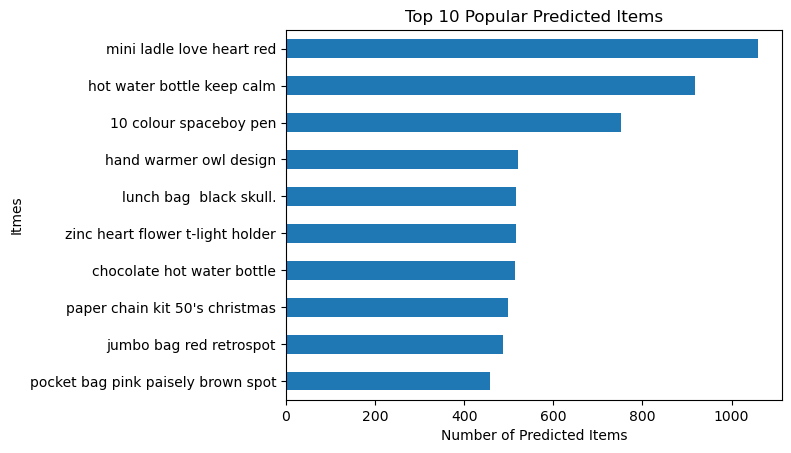

In [302]:
# Top 10 Popular Sold Items
df= result.groupby(["predicted_item"])["predicted_item"].count().sort_values(axis= 0,ascending =False)
df = df[:10,].sort_values(ascending = True)
df.plot(kind = "barh")
plt.ylabel('Itmes')
plt.xlabel('Number of Predicted Items')
plt.title('Top 10 Popular Predicted Items')

Time for generating recommendations using collaborative filtering: 1383.646889925003


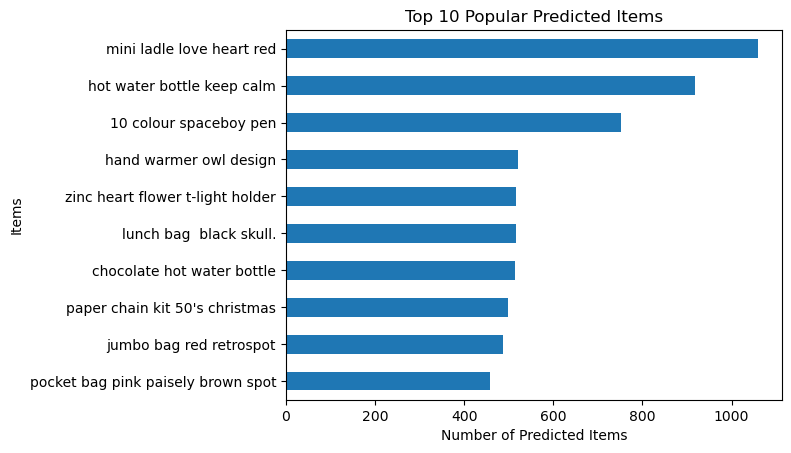

In [303]:
import time
import matplotlib.pyplot as plt

start_time_a = time.time()
new_test_data = test_data.reset_index(drop=True)
result_list = []

for i in range(len(new_test_data)):
    tmp = new_test_data.loc[i]
    item = tmp["Itemname"]
    res = get_recommandation(item, 1)
    result_list.append(pd.DataFrame(res))

result_new = pd.concat(result_list, ignore_index=True)

end_time_a = time.time()
cf_time = end_time_a - start_time_a
print("Time for generating recommendations using collaborative filtering: " + str(cf_time))

# Top 10 Popular Sold Items
df = result_new.groupby(["predicted_item"]).size().nlargest(10).sort_values(ascending=True)
df.plot(kind="barh")
plt.ylabel('Items')
plt.xlabel('Number of Predicted Items')
plt.title('Top 10 Popular Predicted Items')
plt.show()

In [311]:
sorted_data = result_new.groupby(["predicted_item"]).size().nlargest(10).sort_values(ascending=True)
sorted_data[:10]

predicted_item
pocket bag pink paisely brown spot     459
jumbo bag red retrospot                487
paper chain kit 50's christmas         499
chocolate hot water bottle             515
lunch bag  black skull.                517
zinc heart flower t-light holder       517
hand warmer owl design                 520
10 colour spaceboy pen                 751
hot water bottle keep calm             918
mini ladle love heart red             1060
dtype: int64

In [313]:
get_recommandation("mini ladle love heart red",10)

,Itemname,predicted_item,similarity
0,mini ladle love heart red,reindeer heart decoration gold,0.923095
1,mini ladle love heart red,cherub heart decoration silver,0.919474
2,mini ladle love heart red,zinc heart flower t-light holder,0.916157
3,mini ladle love heart red,strawberry bath sponge,0.906144
4,mini ladle love heart red,set of 4 black lovebird coasters,0.905357
5,mini ladle love heart red,tea cosy blue stripe,0.900819
6,mini ladle love heart red,watering can blue elephant,0.896848
7,mini ladle love heart red,set of 4 pistachio lovebird coaster,0.888604
8,mini ladle love heart red,silver record cover frame,0.888297
9,mini ladle love heart red,christmas tree hanging silver,0.871181


In [314]:
get_recommandation("hot water bottle keep calm",10)

,Itemname,predicted_item,similarity
0,hot water bottle keep calm,chocolate hot water bottle,0.624681
1,hot water bottle keep calm,love hot water bottle,0.523127
2,hot water bottle keep calm,mini wooden happy birthday garland,0.514317
3,hot water bottle keep calm,small hanging ivory/red wood bird,0.508535
4,hot water bottle keep calm,50cm metal string with 7 clips,0.505621
5,hot water bottle keep calm,gardeners kneeling pad cup of tea,0.503436
6,hot water bottle keep calm,lipstick pen red,0.500617
7,hot water bottle keep calm,toilet metal sign,0.497830
8,hot water bottle keep calm,wrap christmas village,0.494902
9,hot water bottle keep calm,number tile vintage font 7,0.494902


In [315]:
get_recommandation("10 colour spaceboy pen", 10)

,Itemname,predicted_item,similarity
0,10 colour spaceboy pen,cherry blossom luggage tag,1.0
1,10 colour spaceboy pen,ivory shell heart necklace,1.0
2,10 colour spaceboy pen,vintage bead cosmetic bag,1.0
3,10 colour spaceboy pen,cowboys and indians birthday card,1.0
4,10 colour spaceboy pen,clear crystal star phone charm,1.0
5,10 colour spaceboy pen,"birthday card, retro spot",1.0
6,10 colour spaceboy pen,mini paint set vintage,1.0
7,10 colour spaceboy pen,t-light holder silver saucer,1.0
8,10 colour spaceboy pen,t-light holder white lace,1.0
9,10 colour spaceboy pen,robot birthday card,1.0


In [316]:
get_recommandation("hand warmer owl design",10)

,Itemname,predicted_item,similarity
0,hand warmer owl design,hand warmer red love heart,0.738007
1,hand warmer owl design,hand warmer bird design,0.701074
2,hand warmer owl design,hand warmer scotty dog design,0.700036
3,hand warmer owl design,hand warmer union jack,0.671800
4,hand warmer owl design,hand warmer red retrospot,0.669216
5,hand warmer owl design,hand warmer babushka design,0.601873
6,hand warmer owl design,christmas toilet roll,0.485915
7,hand warmer owl design,popcorn holder,0.425958
8,hand warmer owl design,modern floral stationery set,0.424822
9,hand warmer owl design,12 pencil small tube woodland,0.415783


In [317]:
get_recommandation("zinc heart flower t-light holder",10)

,Itemname,predicted_item,similarity
0,zinc heart flower t-light holder,cherub heart decoration silver,0.929670
1,zinc heart flower t-light holder,mini ladle love heart red,0.916157
2,zinc heart flower t-light holder,love garland painted zinc,0.912871
3,zinc heart flower t-light holder,jungle popsicles ice lolly moulds,0.898146
4,zinc heart flower t-light holder,silver record cover frame,0.898146
5,zinc heart flower t-light holder,emergency first aid tin,0.896421
6,zinc heart flower t-light holder,penny farthing birthday card,0.894427
7,zinc heart flower t-light holder,pens assorted spaceball,0.894427
8,zinc heart flower t-light holder,tea party birthday card,0.894427
9,zinc heart flower t-light holder,pink & white rosebud ring,0.894427


### USER-BASED COLLABORATIVE FILTERING

In [318]:
train_rating_piv_df = pd.DataFrame(pd.pivot_table(train_rating, index='CustomerID', columns='Itemname', values='Rating'))
train_rating_piv_df.fillna(0, inplace=True)
train_rating_piv_df

Itemname,10 colour spaceboy pen,12 coloured party balloons,12 daisy pegs in wood box,12 egg house painted wood,12 ivory rose peg place settings,12 message cards with envelopes,12 pencil small tube woodland,12 pencils small tube red retrospot,12 pencils small tube skull,12 pencils tall tube posy,...,zinc plant pot holder,zinc star t-light holder,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12354,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18281,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18282,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [319]:
similarity_matrix_train_df = pd.DataFrame(cosine_similarity(train_rating_piv_df, train_rating_piv_df), index=train_rating_piv_df.index, columns=train_rating_piv_df.index)
similarity_matrix_train_df

CustomerID,12347,12350,12352,12353,12354,12355,12356,12358,12360,12361,...,18269,18270,18272,18277,18278,18280,18281,18282,18283,18287
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,1.000000,0.0,0.067116,0.0,0.000000,0.109971,0.095238,0.00,0.007377,0.000000,...,0.000000,0.0,0.000000,0.000000,0.134687,0.182574,0.000000,0.0,0.052223,0.0
12350,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
12352,0.067116,0.0,1.000000,0.0,0.053812,0.077498,0.067116,0.00,0.020795,0.000000,...,0.051988,0.0,0.076550,0.000000,0.000000,0.000000,0.000000,0.0,0.023553,0.0
12353,0.000000,0.0,0.000000,1.0,0.000000,0.166667,0.000000,0.25,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0
12354,0.000000,0.0,0.053812,0.0,1.000000,0.000000,0.089087,0.00,0.262225,0.138013,...,0.000000,0.0,0.029031,0.000000,0.000000,0.048795,0.077152,0.0,0.132871,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18280,0.182574,0.0,0.000000,0.0,0.048795,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.129099,1.000000,0.158114,0.0,0.000000,0.0
18281,0.000000,0.0,0.000000,0.0,0.077152,0.000000,0.000000,0.00,0.178885,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.158114,1.000000,0.0,0.050653,0.0
18282,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,...,0.000000,0.0,0.076810,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0


In [320]:
test_rating_piv_df = pd.DataFrame(pd.pivot_table(test_rating, index='CustomerID', columns='Itemname', values='Rating'))
test_rating_piv_df.fillna(0, inplace=True)
test_rating_piv_df

Itemname,10 colour spaceboy pen,12 coloured party balloons,12 egg house painted wood,12 hanging eggs hand painted,12 message cards with envelopes,12 pencil small tube woodland,12 pencils small tube red retrospot,12 pencils small tube skull,12 pencils tall tube red retrospot,12 pencils tall tube skulls,...,zinc herb garden container,zinc metal heart decoration,zinc sweetheart soap dish,zinc sweetheart wire letter rack,zinc t-light holder star large,zinc t-light holder stars small,zinc top 2 door wooden shelf,zinc willie winkie candle stick,zinc wire kitchen organiser,zinc wire sweetheart letter tray
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12356,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12357,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18276,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [321]:
similarity_matrix_test_df = pd.DataFrame(cosine_similarity(test_rating_piv_df, test_rating_piv_df), index=test_rating_piv_df.index,
                                    columns=test_rating_piv_df.index)
similarity_matrix_test_df

CustomerID,12347,12349,12352,12356,12357,12362,12364,12374,12380,12381,...,18245,18249,18257,18261,18270,18272,18274,18276,18282,18283
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,1.000000,0.066667,0.0,0.158114,0.136931,0.076948,0.0,0.055902,0.000000,0.119523,...,0.035806,0.0,0.000000,0.000000,0.0,0.000000,0.091287,0.0,0.111803,0.061648
12349,0.066667,1.000000,0.0,0.105409,0.030429,0.085498,0.0,0.074536,0.052705,0.199205,...,0.167093,0.0,0.000000,0.000000,0.0,0.424264,0.121716,0.0,0.074536,0.046236
12352,0.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.0,0.000000,0.133631,0.000000,...,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000
12356,0.158114,0.105409,0.0,1.000000,0.288675,0.000000,0.0,0.176777,0.000000,0.377964,...,0.113228,0.0,0.000000,0.000000,0.0,0.000000,0.288675,0.0,0.353553,0.000000
12357,0.136931,0.030429,0.0,0.288675,1.000000,0.117073,0.0,0.051031,0.000000,0.109109,...,0.065372,0.0,0.000000,0.000000,0.0,0.000000,0.083333,0.0,0.102062,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18272,0.000000,0.424264,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.101274,0.0,0.000000,0.000000,0.0,1.000000,0.000000,0.0,0.000000,0.032694
18274,0.091287,0.121716,0.0,0.288675,0.083333,0.000000,0.0,0.102062,0.000000,0.436436,...,0.261488,0.0,0.000000,0.000000,0.0,0.000000,1.000000,0.0,0.204124,0.000000
18276,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.065372,0.0,0.000000,0.204124,0.0,0.000000,0.000000,1.0,0.000000,0.000000


In [322]:
def get_prediction(userid, itemname, sim_rating, rating):
    user_rating = rating.loc[:,itemname]
    user_similarity = sim_rating.sort_values(by=userid, ascending=False).loc[:, userid].tolist()
    weighted_sum = np.dot(user_similarity, user_rating)
    weighted_sum /= np.sum(user_similarity)
    return weighted_sum

In [323]:
prediction = []
train_real = train_rating['Rating'].to_numpy()
for _,row in train_rating.iterrows():
    result = get_prediction(row[0], row[1], similarity_matrix_train_df, train_rating_piv_df)
    prediction.append(result)
rmse = np.sqrt(np.mean((train_real - prediction)**2))
print(f'Train data RMSE = {rmse}')

Train data RMSE = 1.7219739569537742


In [324]:
prediction = []
test_real = test_rating['Rating'].to_numpy()
for _,row in test_rating.iterrows():
    result = get_prediction(row[0], row[1], similarity_matrix_test_df, test_rating_piv_df)
    prediction.append(result)
rmse = np.sqrt(np.mean((test_real - prediction)**2))
print(f'Test data RMSE = {rmse}')

Test data RMSE = 1.3484317432682633


### Matrix Factorization using ALS

In [ ]:
# The following code is utiziled from the blog:
#(li,2019)

In [325]:
dataset_mf_big = dataset.copy()

In [326]:
items_per_customer_df = (dataset_mf_big.groupby(["CustomerID"]).agg({"Itemname": "nunique"}).reset_index())

In [327]:
items_per_customer_df.columns = ["CustomerID", "Count_item_cust"]
items_per_customer_df

,CustomerID,Count_item_cust
0,12347,42
1,12349,45
2,12350,2
3,12352,36
4,12353,4
...,...,...
4043,18280,10
4044,18281,4
4045,18282,10
4046,18283,268


In [328]:
# Filtering Results
mask = items_per_customer_df["Count_item_cust"] >= 6
valid_customer = set(items_per_customer_df.loc[mask, "CustomerID"].tolist())
df_filter_cust = dataset[dataset["CustomerID"].isin(valid_customer)].copy()
billno_filter_cust = set(df_filter_cust["BillNo"].tolist())

In [329]:
# Calculate count of unique customers per item
custs_per_item_df = dataset.groupby(["Itemname"]).agg({"CustomerID": "nunique"}).reset_index()
custs_per_item_df.columns = ["Itemname", "Count_cust_item"]

# Count the occurrences of each unique count of customers per item
counts_per_item = custs_per_item_df["Count_cust_item"].value_counts()
counts_per_item

Count_cust_item
1      278
2      184
3      133
4      125
6      107
      ... 
327      1
260      1
298      1
357      1
257      1
Name: count, Length: 308, dtype: int64

In [330]:
cust_in_item_threshold = 6

In [331]:
# Filter Results
mask = custs_per_item_df["Count_cust_item"] >= cust_in_item_threshold
valid_billnos = set(custs_per_item_df.loc[mask, "Itemname"].tolist())

In [333]:
# Filtering items based on valid stock codes
df_filter_item = dataset[dataset["Itemname"].isin(valid_billnos)].copy()
billnos_filter_item = set(df_filter_item["BillNo"].tolist())

# Finding the intersection of bill numbers
billnos_intersect = set.intersection(billnos_filter_item, billno_filter_cust)

# Printing the counts
print(f"No. of invoices after filtering by customer: {len(billno_filter_cust)}")
print(f"No. of invoices after filtering by item: {len(billnos_filter_item)}")
print(f"No. of invoices from intersection: {len(billnos_intersect)}")


No. of invoices after filtering by customer: 14553
No. of invoices after filtering by item: 15346
No. of invoices from intersection: 14534


In [334]:
df_filter_cust_item = dataset[dataset["BillNo"].isin(billnos_intersect)].copy()

In [335]:
df_filter_cust_item.info()

<class 'pandas.core.frame.DataFrame'>
Index: 258459 entries, 0 to 65325
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   BillNo      258459 non-null  int64         
 1   Itemname    258459 non-null  object        
 2   Quantity    258459 non-null  int64         
 3   Date        258459 non-null  datetime64[ns]
 4   Price       258459 non-null  float64       
 5   CustomerID  258459 non-null  int64         
 6   cost        258459 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(1)
memory usage: 15.8+ MB


In [336]:
unique_customers_filter = df_filter_cust_item["CustomerID"].unique()
customer_ids = dict(zip(unique_customers_filter, np.arange(unique_customers_filter.shape[0], dtype=np.int32)))

In [337]:
unique_items_filter = df_filter_cust_item["Itemname"].unique()
item_ids_filter = dict(zip(unique_items_filter, np.arange(unique_items_filter.shape[0], dtype=np.int32)))

In [338]:
df_filter_cust_item["customer_id"] = df_filter_cust_item["CustomerID"].apply(lambda i: customer_ids[i])
df_filter_cust_item["item_id"] = df_filter_cust_item["Itemname"].apply(lambda i: item_ids_filter[i])

In [339]:
print(f"{len(customer_ids)}, {len(item_ids_filter)}")

3430, 3668


In [340]:
df_filter_cust_item.sort_values(by=["Itemname"], inplace=True)
df_filter_cust_item.head(10)

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost,customer_id,item_id
56605,547358,10 colour spaceboy pen,6,2011-03-22 12:25:00,0.85,15998,5.10,520,800
47415,545658,10 colour spaceboy pen,5,2011-03-04 14:13:00,0.85,14670,4.25,1448,800
3291,536993,10 colour spaceboy pen,2,2010-12-03 15:19:00,0.85,14396,1.70,169,800
17683,539663,10 colour spaceboy pen,1,2010-12-21 10:26:00,0.85,17961,0.85,139,800
175387,569246,10 colour spaceboy pen,3,2011-10-03 09:57:00,1.63,14096,4.89,2682,800
7272,573576,10 colour spaceboy pen,1,2011-10-31 14:09:00,1.63,14096,1.63,2682,800
190739,571441,10 colour spaceboy pen,2,2011-10-17 13:31:00,1.63,14096,3.26,2682,800
169221,568346,10 colour spaceboy pen,1,2011-09-26 15:28:00,1.63,14096,1.63,2682,800
59800,580727,10 colour spaceboy pen,3,2011-12-05 17:17:00,1.63,14096,4.89,2682,800
133249,562106,10 colour spaceboy pen,1,2011-08-02 15:19:00,0.85,14076,0.85,2579,800


In [341]:
df_cust_item_qty = df_filter_cust_item.groupby(["customer_id", "item_id"])["Quantity"].sum().reset_index()

In [342]:
df_cust_item_qty.head()

,customer_id,item_id,Quantity
0,0,0,98
1,0,1,92
2,0,2,86
3,0,3,104
4,0,4,42


In [343]:
sparse_customer_item = sparse.csr_matrix((df_cust_item_qty["Quantity"].astype(float), (df_cust_item_qty["customer_id"], df_cust_item_qty["item_id"])))

In [344]:
model = implicit.als.AlternatingLeastSquares(num_threads=1)
model.fit(sparse_customer_item)

  0%|          | 0/15 [00:00<?, ?it/s]

In [345]:
item_vecs = model.item_factors
customer_vecs = model.user_factors

In [346]:
ref_item_id = df_filter_cust_item["item_id"].unique()

# Check the type of ref_item_id
print(type(ref_item_id))

<class 'numpy.ndarray'>


In [347]:
similar_items, scores = model.similar_items(ref_item_id, N=10)
# Create a DataFrame from similar_items
df_similar_items = pd.DataFrame(similar_items)
# Add a column for the reference item ID
df_similar_items["Ref Item ID"] = ref_item_id
# Display the first few rows of the DataFrame
print(df_similar_items.head())

      0     1     2     3     4     5     6     7     8     9  Ref Item ID
0   800  2427  2677  1279  2117  3098  1046  3360  2374  2733          800
1   870   145  1099  1315  2211  1211  1021  2113  1690  1770          870
2   255  1013  2050  1530  1089   775  2024  1122  2206  2228          255
3  2120  2161   843  2686  2255  2180   652  2617   701  1359         2120
4  3628  3641  3576  3222  2958  2957  3663  2343   147  3505         3628


In [348]:
df_item_rank = pd.melt(df_similar_items.rename(columns={"Ref Item ID": "Ref_Item_ID"}), id_vars=["Ref_Item_ID"], var_name=["Item Rank"], value_name="Related Item ID")

In [349]:
df_item_rank_sorted = df_item_rank.sort_values(by=["Related Item ID", "Item Rank"]).head(20)
df_item_rank_sorted

,Ref_Item_ID,Item Rank,Related Item ID
1710,0,0,0
8412,175,2,0
9954,3,2,0
14544,122,3,0
30921,3259,8,0
1350,1,0,1
4441,680,1,1
21866,2,5,1
33568,152,9,1
3526,2,0,2


In [350]:
df_score_rank = pd.DataFrame(scores).assign(Ref_Item_ID=ref_item_id).melt(id_vars=["Ref_Item_ID"], var_name=["Item Rank"], value_name="Score").sort_values(["Ref_Item_ID", "Item Rank"]).head(20)
df_score_rank

,Ref_Item_ID,Item Rank,Score
1710,0,0,1.000000
5378,0,1,0.561790
9046,0,2,0.537527
12714,0,3,0.513968
16382,0,4,0.483869
20050,0,5,0.450601
23718,0,6,0.434701
27386,0,7,0.425880
31054,0,8,0.421947
34722,0,9,0.419446


In [351]:
df_item_score = df_item_rank.merge(df_score_rank, how="inner", on=["Ref_Item_ID", "Item Rank"]).sort_values(["Ref_Item_ID", "Item Rank"]).head(20)
df_item_score

,Ref_Item_ID,Item Rank,Related Item ID,Score
1,0,0,0,1.000000
3,0,1,3,0.561790
5,0,2,3253,0.537527
7,0,3,122,0.513968
9,0,4,175,0.483869
11,0,5,3427,0.450601
13,0,6,3578,0.434701
15,0,7,2709,0.425880
17,0,8,2748,0.421947
19,0,9,3511,0.419446


In [352]:
df_item_desc = df_filter_cust_item[["item_id", "Itemname"]].drop_duplicates(subset=["item_id"])

In [353]:
df_similar_item_temp = df_item_score.merge(df_item_desc, how="left", left_on="Ref_Item_ID", right_on="item_id")

In [354]:
df_similar_item_temp.drop(columns=["item_id"], inplace=True)
df_similar_item_temp.columns = [
    "Ref Item ID",
    "Item Rank",
    "Related Item ID",
    "Score",
    "Ref_BillNO",
]

In [355]:
df_similar_item_temp.shape
df_similar_item_temp.head()

,Ref Item ID,Item Rank,Related Item ID,Score,Ref_BillNO
0,0,0,0,1.000000,knitted union flag hot water bottle
1,0,1,3,0.561790,knitted union flag hot water bottle
2,0,2,3253,0.537527,knitted union flag hot water bottle
3,0,3,122,0.513968,knitted union flag hot water bottle
4,0,4,175,0.483869,knitted union flag hot water bottle


In [356]:
df_similar_item_final = df_similar_item_temp.merge(df_item_desc, how="left", left_on="Related Item ID", right_on="item_id")
df_similar_item_final.drop(columns=["item_id"], inplace=True)
df_similar_item_final.columns = [
    "Ref Item ID",
    "Item Rank",
    "Related Item ID",
    "Score",
    "Ref_BillNO",
    "Related_BillNO",
]
df_similar_item_final.head()

,Ref Item ID,Item Rank,Related Item ID,Score,Ref_BillNO,Related_BillNO
0,0,0,0,1.000000,knitted union flag hot water bottle,knitted union flag hot water bottle
1,0,1,3,0.561790,knitted union flag hot water bottle,red woolly hottie white heart.
2,0,2,3253,0.537527,knitted union flag hot water bottle,hot water bottle sex bomb
3,0,3,122,0.513968,knitted union flag hot water bottle,white skull hot water bottle
4,0,4,175,0.483869,knitted union flag hot water bottle,english rose hot water bottle


In [357]:
df_cust_id_map = df_filter_cust_item[["CustomerID", "customer_id"]].drop_duplicates(subset="customer_id")

In [358]:
df_cust_id_map.head(20)

,CustomerID,customer_id
56605,15998,520
47415,14670,1448
3291,14396,169
17683,17961,139
175387,14096,2682
133249,14076,2579
115341,17888,691
1696,14390,90
150527,16983,202
122204,18283,763


In [359]:
CustomerID = 16714
cust_id = df_cust_id_map[df_cust_id_map["CustomerID"] == CustomerID]["customer_id"].item()
print(cust_id)

1017


In [360]:
df_filter_cust_item[df_filter_cust_item["customer_id"] == cust_id]

,BillNo,Itemname,Quantity,Date,Price,CustomerID,cost,customer_id,item_id
29393,542231,12 coloured party balloons,10,2011-01-26 13:40:00,0.65,16714,6.50,1017,870
29347,542231,3d hearts honeycomb paper garland,6,2011-01-26 13:40:00,2.95,16714,17.70,1017,2351
29379,542231,alarm clock bakelike green,2,2011-01-26 13:40:00,3.75,16714,7.50,1017,76
29348,542231,alarm clock bakelike red,2,2011-01-26 13:40:00,3.75,16714,7.50,1017,106
29354,542231,alphabet hearts sticker sheet,3,2011-01-26 13:40:00,0.85,16714,2.55,1017,1347
...,...,...,...,...,...,...,...,...,...
29389,542231,toast its - i love you,1,2011-01-26 13:40:00,1.25,16714,1.25,1017,1240
29344,542231,vintage red kitchen cabinet,2,2011-01-26 13:40:00,125.00,16714,250.00,1017,1927
29409,542231,white hanging heart t-light holder,6,2011-01-26 13:40:00,2.95,16714,17.70,1017,2
29385,542231,wood stamp set thank you,4,2011-01-26 13:40:00,1.65,16714,6.60,1017,1256


In [361]:
ids, scores = model.recommend(cust_id, sparse_customer_item[cust_id], N=20, filter_already_liked_items=False)
list_billno = df_item_desc[df_item_desc["item_id"].isin(ids)]["Itemname"].tolist()
df_recommendations = pd.DataFrame(
    {
        "BillNo": list_billno,
        "score": scores,
        "already_liked": np.in1d(ids, sparse_customer_item[cust_id].indices),
    }
)
df_recommendations

,BillNo,score,already_liked
0,12 coloured party balloons,1.040139,True
1,assorted colour bird ornament,1.006281,True
2,baking mould chocolate cupcakes,0.954163,True
3,coffee mug apples design,0.921526,True
4,coffee mug pears design,0.872220,True
5,feltcraft 6 flower friends,0.870919,True
6,feltcraft butterfly hearts,0.865418,True
7,happy stencil craft,0.861628,True
8,heart of wicker large,0.841519,True
9,hearts stickers,0.841251,True


In [362]:
def get_prediction(model):
    predictions = []
    for customer_id in df_cust_id_map['customer_id']:
        filtered_df = df_filter_cust_item[df_filter_cust_item["customer_id"] == customer_id]
        ids, scores = model.recommend(customer_id, sparse_customer_item[customer_id], N=20, filter_already_liked_items=False)
        list_billno = df_item_desc[df_item_desc["item_id"].isin(ids)]["Itemname"].tolist()
        df_recommendations = pd.DataFrame({
            "customer_id": customer_id,
            "BillNO": list_billno,
            "score": scores,
            "already_liked": np.in1d(ids, sparse_customer_item[customer_id].indices),
        })
        predictions.append(df_recommendations)

    return pd.concat(predictions, ignore_index=True)

predictions = get_prediction(model)

In [363]:
predictions.head(50)

,customer_id,BillNO,score,already_liked
0,520,blue polkadot cup,2.083505,True
1,520,card holder gingham heart,1.336113,True
2,520,childrens apron apples design,1.282804,True
3,520,childrens apron spaceboy design,1.242758,True
4,520,doormat hearts,1.233156,True
5,520,doormat keep calm and come in,1.233052,True
6,520,doormat union flag,1.226650,True
7,520,gardeners kneeling pad cup of tea,1.223173,True
8,520,gymkhana treasure book box,1.222684,True
9,520,heart of wicker small,1.219924,True


In [364]:
#(li,2019)
def make_train(ratings, pct_test=0.2):
    # Make a copy of the original set to be the test set
    test_set = ratings.copy()
    # Store the test set as a binary preference matrix
    test_set[test_set != 0] = 1

    # Make a copy of the original data we can alter as our training set
    training_set = ratings.copy()

    # Find the indices in the ratings data where an interaction exists
    nonzero_inds = training_set.nonzero()
    # Zip these pairs together of item,user index into list
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1]))

    # Set the random seed for reproducibility
    random.seed(0)

    # Round the number of samples needed to the nearest integer
    num_samples = int(np.ceil(pct_test * len(nonzero_pairs)))
    # Sample a random number of item-user pairs without replacement
    samples = random.sample(nonzero_pairs, num_samples)

    # Get the item row indices
    item_inds = [index[0] for index in samples]
    # Get the user column indices
    customer_inds = [index[1] for index in samples]

    # Assign all of the randomly chosen user-item pairs to zero
    training_set[item_inds, customer_inds] = 0
    # Get rid of zeros in sparse array storage after update to save space
    training_set = csr_matrix(training_set)

    return training_set, test_set, list(set(customer_inds))

item_train, item_test, item_customers_altered = make_train(sparse_customer_item, pct_test=0.2)


In [365]:
def auc_score(predictions, test):
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [366]:
#(li,2019)
def calc_mean_auc(training_set, altered_customers, predictions, test_set):
    store_auc = []  # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = []  # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis=1)).reshape(-1)  # Get sum of item interactions to find most popular
    customer_vecs, item_vecs = predictions
    num_users, num_features = customer_vecs.shape
    predicted_list = []
    actual_list = []
    squared_errors = []  # List to store squared errors for RMSE calculation
    for customer in altered_customers:  # Iterate through each user that had an item altered
        if customer >= num_users:
            # If the index of the altered customer exceeds the number of users, skip
            continue

        training_column = training_set[:, customer].toarray().reshape(-1)  # Get the training set column
        zero_inds = np.where(training_column == 0)[0]  # Find where the interaction had not yet occurred

        # Get the predicted values based on our user/item vectors
        customer_vec = customer_vecs[customer, :]
        pred = np.dot(customer_vec.reshape(1, -1), item_vecs).flatten()[zero_inds]

        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no interaction
        actual = test_set[:, customer].toarray()[zero_inds, 0].reshape(-1)
        actual_list.append(actual)
        predicted_list.append(pred)
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training
        pop = pop_items[zero_inds]  # Get the item popularity for our chosen items

        # Calculate AUC for the given user and store
        store_auc.append(auc_score(pred, actual))
        # Calculate AUC using most popular and store
        popularity_auc.append(auc_score(pop, actual))

        # Calculate squared errors for RMSE calculation
        squared_errors.extend(np.square(actual - pred))

    # Calculate F1 score and recall
    predicted = np.concatenate(predicted_list)
    actual = np.concatenate(actual_list)
    f1 = f1_score(actual, predicted.round(), average='macro')
    recall = recall_score(actual, predicted.round(), average='macro')

    # Calculate Mean Reciprocal Rank (MRR)
    reciprocal_ranks = np.array([1.0 / (np.where(np.argsort(pred)[::-1] == np.where(actual == 1)[0][0])[0][0] + 1)
                                 for pred, actual in zip(predicted_list, actual_list) if len(np.where(actual == 1)[0]) > 0])
    mrr = np.mean(reciprocal_ranks)

    # Calculate RMSE
    rmse = np.sqrt(np.mean(squared_errors))

    return float('%.3f' % np.mean(store_auc)), float('%.3f' % np.mean(popularity_auc)), f1, recall, mrr, rmse

# Call the function
calc_mean_auc(item_train, item_customers_altered,
              [customer_vecs, item_vecs.T], item_test)


(0.508,
 0.804,
 0.19981947537764547,
 0.20114717027387682,
 0.006818137766609793,
 0.14026824258683931)

### References

Li, S. (2019, April 20). towardsdatascience. Retrieved from Building a Collaborative Filtering
Recommender System with ClickStream Data: https://towardsdatascience.com/building-a-collaborative-filtering-recommender-system-withclickstream-data-dffc86c8c65

Liao, K. (2018, November 17). Towards Data Science. Retrieved from Prototyping a Recommender System
Step by Step Part 2: Alternating Least Square (ALS) Matrix Factorization in Collaborative Filtering:
https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-
least-square-als-matrix-4a76c58714a1

Saluja, C. (2018, March 6). Collaborative Filtering based Recommendation Systems exemplified. Retrieved from towardsdatascience: https://towardsdatascience.com/collaborative-filtering-based-recommendation-systems-exemplified-ecbffe1c20b1

Sen, S. (2020, July 21). Evaluating Recommender Systems. Retrieved from Medium:
https://medium.com/the-owl/evaluating-recommender-systems-749570354976